# Ben Earnest

# Andrew Kim

# Grigor Tashchyan

# A Sentiment Analysis of MLB Performance

## ADS-509 Final Project Team 11

### Libraries

In [1]:
#Install reqired libraries
!pip install beautifulsoup4 requests
!pip install tqdm

In [2]:
#Import required libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string
from string import punctuation
from wordcloud import WordCloud 
import re
from collections import Counter
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

##### The first step in our effort is to scrape blog post text from the mlbtraderumors.com website. This posts include text, dates posted, and the authors name. We will scrape this information and store it in a dataframe that we can use to start our text analysis.

## Functions to Acquire Text Data

In [3]:
def scrape_website(url, file_path):
    #Send a GET request to the website
    response = requests.get(url)

    #Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    #Find all the news article elements
    articles = soup.find_all("article")

    #Create lists to store the extracted values
    titles = []
    authors = []
    dates = []
    contents = []

    #Iterate over the articles and extract the text
    with open(file_path, "w", encoding="utf-8") as file:
        for article in articles:
            #Extract the article title
            title_element = article.find("h2")
            title = title_element.text.strip() if title_element else ""
            titles.append(title)

            #Extract the article author
            author_element = article.find("span", class_="entry-author")
            author = author_element.text.strip() if author_element else ""
            authors.append(author)

            #Extract the article date
            date_element = article.find("time", class_="entry-time")
            date = date_element.text.strip() if date_element else ""
            dates.append(date)

            #Extract the article content
            content_element = article.find("div", class_="entry-content")
            content = content_element.text.strip() if content_element else ""
            contents.append(content)

            #Write the title and content to the file
            file.write("Title: " + title + "\n")
            file.write("Author: " + author + "\n")
            file.write("Date: " + date + "\n")
            file.write("Content: " + content + "\n")
            file.write("---\n")

    #Create a DataFrame from the extracted values
    data = {
        "Title": titles,
        "Author": authors,
        "Date": dates,
        "Content": contents
    }

    df = pd.DataFrame(data)

    #Drop rows without content
    df.dropna()

    return df

# Washington Nationals Data Collection and Cleaning

In [4]:
#URL of the website to scrape
url = "https://www.mlbtraderumors.com/washington-nationals?show=all"
file_path = "C:/Users/andre/OneDrive/Project/mlbtraderumors_washington_nationals_articles1.txt"

#Scrape the website, write the scraped text to a file, and get the head of the DataFrame
wsh_df = scrape_website(url, file_path)
wsh_df.head()

,Title,Author,Date,Content
0,Nationals Designate Chad Kuhl For Assignment,Nick Deeds,"June 24, 2023",The Nationals announced this evening that the ...
1,"Nationals Select Derek Hill, Place Victor Robl...",Steve Adams,"June 21, 2023",The Nationals have selected the contract of ou...
2,"Nationals, Orioles Reach Settlement On 2012-16...",Anthony Franco,"June 20, 2023",The Nationals and Orioles have settled their d...
3,"Sean Doolittle Completes Rehab Assignment, Hea...",Steve Adams,"June 15, 2023",Veteran lefty Sean Doolittle was transferred f...
4,Nationals Release Erasmo Ramírez,Darragh McDonald,"June 9, 2023",The Nationals have released right-hander Erasm...


In [5]:
#Change the Data column to a datetime object:
wsh_df['Date'] = pd.to_datetime(wsh_df['Date'], format="%B %d, %Y", errors= 'coerce')

In [6]:
wsh_df.dtypes

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object

In [7]:
#Check for missing values
wsh_df.isna().sum()

Title       0
Author      0
Date       30
Content     0
dtype: int64

In [8]:
len(wsh_df)

1030

In [9]:
wsh_df = wsh_df.dropna()
wsh_df

,Title,Author,Date,Content
0,Nationals Designate Chad Kuhl For Assignment,Nick Deeds,2023-06-24,The Nationals announced this evening that the ...
1,"Nationals Select Derek Hill, Place Victor Robl...",Steve Adams,2023-06-21,The Nationals have selected the contract of ou...
2,"Nationals, Orioles Reach Settlement On 2012-16...",Anthony Franco,2023-06-20,The Nationals and Orioles have settled their d...
3,"Sean Doolittle Completes Rehab Assignment, Hea...",Steve Adams,2023-06-15,Veteran lefty Sean Doolittle was transferred f...
4,Nationals Release Erasmo Ramírez,Darragh McDonald,2023-06-09,The Nationals have released right-hander Erasm...
...,...,...,...,...
995,"Nationals, Anthony Rendon Not Progressing Towa...",Connor Byrne,2019-07-01,The underrating of Nationals third baseman Ant...
996,Tigers Sign Trevor Rosenthal,TC Zencka,2019-06-29,The Tigers agreed to terms with Trevor Rosenth...
997,"Nationals Option Michael A. Taylor, Activate R...",Steve Adams,2019-06-28,1:55pm: The Nationals have announced the moves...
998,"Nationals Notes: Deadline, Scherzer, Zimmerman",Steve Adams,2019-06-28,The resurgent Nationals have won eight of thei...


In [10]:
len(wsh_df)

1000

## Import data on the Washington Nationals from baseball-reference.com

https://www.baseball-reference.com/teams/WSN/attend.shtml

In [11]:
#URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/WSN/attend.shtml"

#Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

#Select the table of interest (index 0 in this case)
table = tables[0]

#Save the DataFrame as a CSV file
file_path = "C:/Users/andre/OneDrive/Project/MLB_data/nationals_statistics.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)

Data saved to C:/Users/andre/OneDrive/Project/MLB_data/nationals_statistics.csv


In [12]:
path = "C:/Users/andre/OneDrive/Project/MLB_data/"

nationals_df = pd.DataFrame(pd.read_csv(path + 'nationals_statistics.csv'))
nationals_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Washington Nationals,NL East,29,47,5,NaN,861885.0,21547.0,11th of 15,"$98,376,067",96,94,Nationals Park
1,2022,Washington Nationals,NL East,55,107,5,NaN,2026401.0,25017.0,11th of 15,"$125,051,666",96,94,Nationals Park
2,2021,Washington Nationals,NL East,65,97,5,NaN,1465543.0,18093.0,12th of 15,"$172,370,147",96,95,Nationals Park
3,2020,Washington Nationals,NL East,26,34,5,NaN,NaN,NaN,15th of 15,"$172,237,283",99,99,Nationals Park
4,2019,Washington Nationals,NL East,93,69,2,Won WS (4-3),2259781.0,27899.0,11th of 15,"$203,016,595",102,102,Nationals Park


In [13]:
nationals_df= nationals_df[nationals_df['Year'] > 2004]
nationals_df

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Washington Nationals,NL East,29,47,5,NaN,861885.0,21547.0,11th of 15,"$98,376,067",96,94,Nationals Park
1,2022,Washington Nationals,NL East,55,107,5,NaN,2026401.0,25017.0,11th of 15,"$125,051,666",96,94,Nationals Park
2,2021,Washington Nationals,NL East,65,97,5,NaN,1465543.0,18093.0,12th of 15,"$172,370,147",96,95,Nationals Park
3,2020,Washington Nationals,NL East,26,34,5,NaN,NaN,NaN,15th of 15,"$172,237,283",99,99,Nationals Park
4,2019,Washington Nationals,NL East,93,69,2,Won WS (4-3),2259781.0,27899.0,11th of 15,"$203,016,595",102,102,Nationals Park
5,2018,Washington Nationals,NL East,82,80,2,NaN,2529604.0,31230.0,8th of 15,"$188,886,699",105,106,Nationals Park
6,2017,Washington Nationals,NL East,97,65,1,Lost NLDS (3-2),2524980.0,31173.0,7th of 15,"$175,587,301",103,104,Nationals Park
7,2016,Washington Nationals,NL East,95,67,1,Lost NLDS (3-2),2481938.0,30641.0,7th of 15,"$152,967,400",102,103,Nationals Park
8,2015,Washington Nationals,NL East,83,79,2,NaN,2619843.0,32344.0,5th of 15,"$176,496,372",101,102,Nationals Park
9,2014,Washington Nationals,NL East,96,66,1,Lost NLDS (3-1),2579389.0,31844.0,7th of 15,"$137,235,080",102,104,Nationals Park


In [14]:
#Remove the dollar and comma signs from the 'Estimated Payroll' column:
nationals_df['Est. Payroll'] = nationals_df['Est. Payroll'].replace({'\$':''}, regex = True)
nationals_df['Est. Payroll'] = nationals_df['Est. Payroll'].replace({'\,':''}, regex = True)
nationals_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Washington Nationals,NL East,29,47,5,NaN,861885.0,21547.0,11th of 15,98376067,96,94,Nationals Park
1,2022,Washington Nationals,NL East,55,107,5,NaN,2026401.0,25017.0,11th of 15,125051666,96,94,Nationals Park
2,2021,Washington Nationals,NL East,65,97,5,NaN,1465543.0,18093.0,12th of 15,172370147,96,95,Nationals Park
3,2020,Washington Nationals,NL East,26,34,5,NaN,NaN,NaN,15th of 15,172237283,99,99,Nationals Park
4,2019,Washington Nationals,NL East,93,69,2,Won WS (4-3),2259781.0,27899.0,11th of 15,203016595,102,102,Nationals Park


In [15]:
nationals_df['Est. Payroll'] = nationals_df['Est. Payroll'].astype(float)
nationals_df.dtypes

Year              int64
Tm               object
Lg               object
W                 int64
L                 int64
Finish            int64
Playoffs         object
Attendance      float64
Attend/G        float64
Rank             object
Est. Payroll    float64
PPF               int64
BPF               int64
Stadium          object
dtype: object

### Create Binary feature that defines a successful year as wins greater than or equal to 50% of total games played

In [16]:
#Add a column to define a binary output that has a 1 if the team has a winning record for the year, and 0 if they do not
nationals_df['success'] = (nationals_df['W'] / (nationals_df['W'] + nationals_df['L']) >= 0.5).astype(int)
nationals_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium,success
0,2023,Washington Nationals,NL East,29,47,5,NaN,861885.0,21547.0,11th of 15,98376067.0,96,94,Nationals Park,0
1,2022,Washington Nationals,NL East,55,107,5,NaN,2026401.0,25017.0,11th of 15,125051666.0,96,94,Nationals Park,0
2,2021,Washington Nationals,NL East,65,97,5,NaN,1465543.0,18093.0,12th of 15,172370147.0,96,95,Nationals Park,0
3,2020,Washington Nationals,NL East,26,34,5,NaN,NaN,NaN,15th of 15,172237283.0,99,99,Nationals Park,0
4,2019,Washington Nationals,NL East,93,69,2,Won WS (4-3),2259781.0,27899.0,11th of 15,203016595.0,102,102,Nationals Park,1


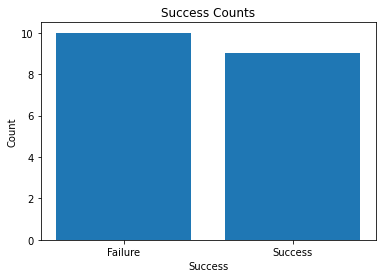

In [17]:
#Count the number of successes and failures
success_counts = nationals_df['success'].value_counts()

#Create a bar plot
plt.bar(success_counts.index, success_counts.values)
plt.xticks(success_counts.index, ['Failure', 'Success'])
plt.xlabel('Success')
plt.ylabel('Count')
plt.title('Success Counts')

#Display the plot
plt.show()

In [18]:
nationals_df.describe()

,Year,W,L,Finish,Attendance,Attend/G,Est. Payroll,PPF,BPF,success
count,19.000000,19.000000,19.000000,19.000000,1.800000e+01,18.000000,1.900000e+01,19.000000,19.000000,19.000000
mean,2014.000000,73.526316,78.473684,3.368421,2.172645e+06,27465.277778,1.163850e+08,99.526316,99.263158,0.473684
std,5.627314,21.103892,19.074032,1.738790,4.799247e+05,4570.628748,5.466072e+07,2.988281,3.983886,0.512989
min,2005.000000,26.000000,34.000000,1.000000,8.618850e+05,18093.000000,3.694750e+07,95.000000,94.000000,0.000000
25%,2009.500000,62.000000,66.500000,2.000000,1.941312e+06,24062.500000,6.604250e+07,96.000000,95.000000,0.000000
50%,2014.000000,80.000000,80.000000,4.000000,2.290090e+06,28452.000000,1.124932e+08,100.000000,99.000000,0.000000
75%,2018.500000,89.500000,92.000000,5.000000,2.528448e+06,31215.750000,1.723037e+08,101.500000,102.500000,1.000000
max,2023.000000,98.000000,107.000000,5.000000,2.731993e+06,33728.000000,2.030166e+08,105.000000,106.000000,1.000000


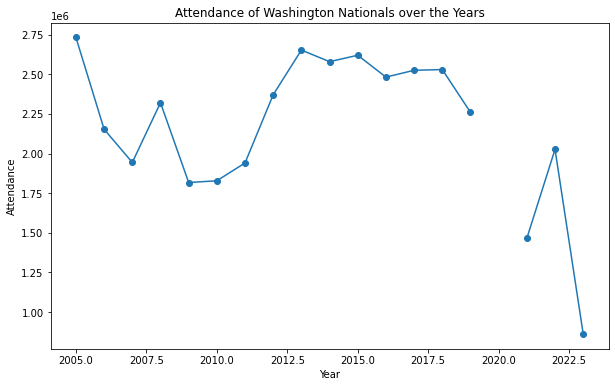

In [19]:
#Plotting the data
#Convert columns to numpy arrays
year = np.array(nationals_df['Year'])
attendance = np.array(nationals_df['Attendance'])

plt.figure(figsize=(10, 6))

#Plotting Attendance over the years
plt.plot(year, attendance, marker='o')
plt.xlabel('Year')
plt.ylabel('Attendance')
plt.title('Attendance of Washington Nationals over the Years')

#Display the plot
plt.show()

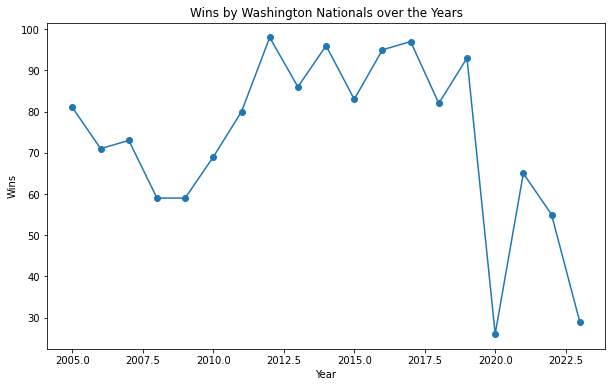

In [20]:
#Plotting Wins over the years
year = np.array(nationals_df['Year'])
wins = np.array(nationals_df['W'])

plt.figure(figsize= (10,6))

#Plotting Attendance over the years
plt.plot(year, wins, marker='o')
plt.xlabel('Year')
plt.ylabel('Wins')
plt.title('Wins by Washington Nationals over the Years')

#Display the plot
plt.show()

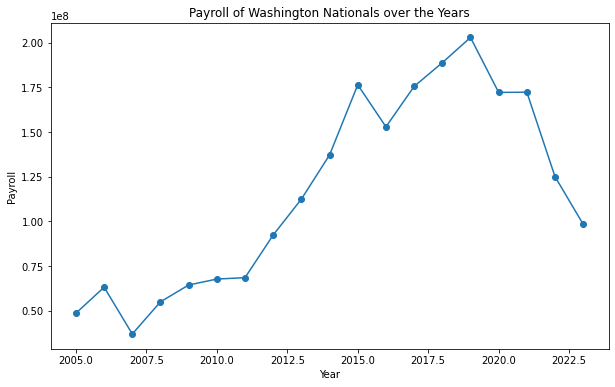

In [21]:
#Plotting Payroll over the years
#Convert columns to numpy arrays
year = np.array(nationals_df['Year'])
payroll = np.array(nationals_df['Est. Payroll'])

plt.figure(figsize= (10,6))

#Plotting Attendance over the years
plt.plot(year, payroll, marker='o')
plt.xlabel('Year')
plt.ylabel('Payroll')
plt.title('Payroll of Washington Nationals over the Years')

#Display the plot
plt.show()

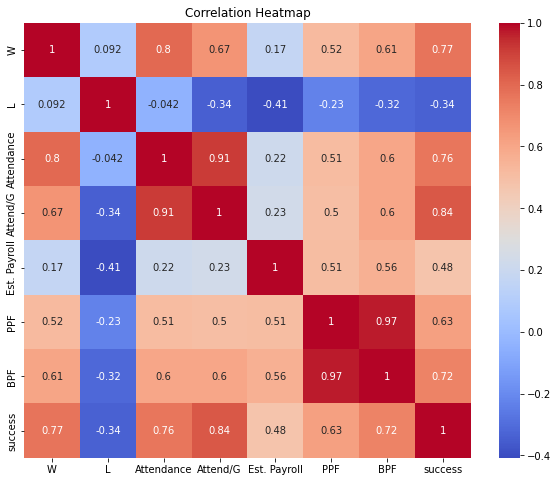

In [22]:
#Select numeric columns for correlation analysis
numeric_cols = ['W', 'L', 'Attendance', 'Attend/G', 'Est. Payroll', 'PPF', 'BPF', 'success']
numeric_df = nationals_df[numeric_cols]

#Correlation matrix
correlation = numeric_df.corr()

#Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

#Display the plot
plt.show()

### Add column to for whether blog post occurred in a successful year or not.

In [23]:
#Extract the year from the "Date" column in df DataFrame
wsh_df['Year'] = pd.to_datetime(wsh_df['Date']).dt.year

#Merge df and athletics_df DataFrames on the "Year" column
merged_wsh_df = pd.merge(wsh_df, nationals_df[['Year', 'success']], on='Year', how='left')

#Add a new column 'Year_Successful' based on 'success' column
merged_wsh_df['Year_Successful'] = merged_wsh_df['success'].fillna(0).astype(int)

merged_wsh_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful
0,Nationals Designate Chad Kuhl For Assignment,Nick Deeds,2023-06-24,The Nationals announced this evening that the ...,2023,0,0
1,"Nationals Select Derek Hill, Place Victor Robl...",Steve Adams,2023-06-21,The Nationals have selected the contract of ou...,2023,0,0
2,"Nationals, Orioles Reach Settlement On 2012-16...",Anthony Franco,2023-06-20,The Nationals and Orioles have settled their d...,2023,0,0
3,"Sean Doolittle Completes Rehab Assignment, Hea...",Steve Adams,2023-06-15,Veteran lefty Sean Doolittle was transferred f...,2023,0,0
4,Nationals Release Erasmo Ramírez,Darragh McDonald,2023-06-09,The Nationals have released right-hander Erasm...,2023,0,0


In [24]:
len(merged_wsh_df)

1000

## Cleaning the Nationals' Data

*Here, we will look for any noise in the data, and also calculate the impurity:

In [25]:
#Identify any noise in the data
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)


In [26]:
merged_wsh_df['Content'].apply

<bound method Series.apply of 0      The Nationals announced this evening that the ...
1      The Nationals have selected the contract of ou...
2      The Nationals and Orioles have settled their d...
3      Veteran lefty Sean Doolittle was transferred f...
4      The Nationals have released right-hander Erasm...
                             ...                        
995    The underrating of Nationals third baseman Ant...
996    The Tigers agreed to terms with Trevor Rosenth...
997    1:55pm: The Nationals have announced the moves...
998    The resurgent Nationals have won eight of thei...
999    Right-hander Alex Meyer has announced his reti...
Name: Content, Length: 1000, dtype: object>

In [27]:
pd.options.display.max_colwidth = 100 ###
#Add new column to data frame
merged_wsh_df['impurity'] = merged_wsh_df['Content'].apply(impurity, min_len=10)

#Get the top 3 records
merged_wsh_df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
604,The Nationals announced they’ve selected the contract of right-hander Steven Fuentes. The 23-yea...,0.003333
562,"Kyle Schwarber is now a member of the Washington Nationals, in no small part because of Nats man...",0.003155
568,The Nationals accomplished a big part of their winter to-do list when they acquired Josh Bell fr...,0.002786


The above shows the highest impurity levels for the Nationals' data set. Note, these are extremely low...well below 1% of all characters in each blog post are suspicious.

## Implement Character Normalization and Tokenization on Nationals' Data

In [28]:

#Example function to normalize the text in the "Contents" column
def normalize_text(text):
    #Lowercase the text
    text = text.lower()

    #Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    #Remove special characters and digits
    text = re.sub(r"[^a-zA-Z]", " ", text)

    #Tokenize the text
    tokens = word_tokenize(text)

    #Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    #Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

#Apply normalization to the "Contents" column
merged_wsh_df["Contents_Normalized"] = merged_wsh_df["Content"].apply(normalize_text)

#Print the head of the DataFrame with the normalized contents
merged_wsh_df[["Content", "Contents_Normalized"]].head()
 	

,Content,Contents_Normalized
0,The Nationals announced this evening that the club has designated right-hander Chad Kuhl for ass...,"[nation, announc, even, club, design, righthand, chad, kuhl, assign, correspond, move, washingto..."
1,"The Nationals have selected the contract of outfielder Derek Hill from Triple-A Rochester, per a...","[nation, select, contract, outfield, derek, hill, triplea, rochest, per, team, announc, correspo..."
2,"The Nationals and Orioles have settled their dispute regarding MASN rights fees between 2012-16,...","[nation, oriol, settl, disput, regard, masn, right, fee, first, report, chelsea, jane, ben, stra..."
3,Veteran lefty Sean Doolittle was transferred from the Nationals’ Double-A affiliate to their Tri...,"[veteran, lefti, sean, doolittl, transfer, nation, doublea, affili, triplea, club, thursday, sig..."
4,"The Nationals have released right-hander Erasmo Ramírez, according to his transactions tracker a...","[nation, releas, righthand, erasmo, ram, rez, accord, transact, tracker, mlbcom, design, assign,..."


In [29]:
merged_wsh_df['length'] = merged_wsh_df['Contents_Normalized'].str.len()
merged_wsh_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length
0,Nationals Designate Chad Kuhl For Assignment,Nick Deeds,2023-06-24,The Nationals announced this evening that the club has designated right-hander Chad Kuhl for ass...,2023,0,0,0.0,"[nation, announc, even, club, design, righthand, chad, kuhl, assign, correspond, move, washingto...",240
1,"Nationals Select Derek Hill, Place Victor Robles On Injured List",Steve Adams,2023-06-21,"The Nationals have selected the contract of outfielder Derek Hill from Triple-A Rochester, per a...",2023,0,0,0.0,"[nation, select, contract, outfield, derek, hill, triplea, rochest, per, team, announc, correspo...",239
2,"Nationals, Orioles Reach Settlement On 2012-16 MASN Rights Fees",Anthony Franco,2023-06-20,"The Nationals and Orioles have settled their dispute regarding MASN rights fees between 2012-16,...",2023,0,0,0.0,"[nation, oriol, settl, disput, regard, masn, right, fee, first, report, chelsea, jane, ben, stra...",274
3,"Sean Doolittle Completes Rehab Assignment, Heads To Triple-A Rochester",Steve Adams,2023-06-15,Veteran lefty Sean Doolittle was transferred from the Nationals’ Double-A affiliate to their Tri...,2023,0,0,0.0,"[veteran, lefti, sean, doolittl, transfer, nation, doublea, affili, triplea, club, thursday, sig...",60
4,Nationals Release Erasmo Ramírez,Darragh McDonald,2023-06-09,"The Nationals have released right-hander Erasmo Ramírez, according to his transactions tracker a...",2023,0,0,0.0,"[nation, releas, righthand, erasmo, ram, rez, accord, transact, tracker, mlbcom, design, assign,...",130


## Analyze descriptive statistics for text in dataframe

<Axes: >

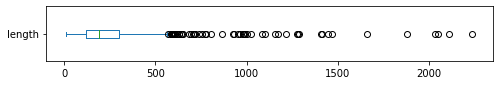

In [30]:
merged_wsh_df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: >

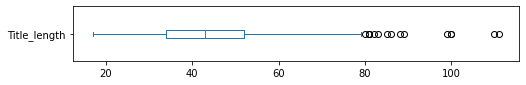

In [31]:
merged_wsh_df['Title_length'] = merged_wsh_df['Title'].str.len()
merged_wsh_df['Title_length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: title={'center': 'Avg. Post Length'}, xlabel='Month'>

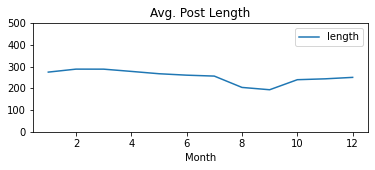

In [32]:
#Extract the month from the date and create a new column
merged_wsh_df['Month'] = merged_wsh_df['Date'].dt.month

#Plot the average post length
merged_wsh_df.groupby('Month').agg({'length': 'mean'}) \
  .plot(title="Avg. Post Length", ylim=(0,500), figsize=(6,2))

In [33]:
def count_words(df, column='Contents_Normalized', preprocess=None, min_freq=2):

    #Process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    #Create counter and run through all data
    counter = Counter()
    tqdm.pandas() #initialize tqdm for progress bar
    df[column].apply(update)

    #Transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [34]:
freq_df = count_words(merged_wsh_df)
freq_df.head(5)

,freq
token,
season,3106
nation,2760
year,2407
leagu,1807
nat,1609


In [35]:
#How many tokens are in the df?
len(freq_df)

6442

In [36]:
#Top words with 10+ characters
count_words(merged_wsh_df, column='Content', 
            preprocess=lambda Content: re.findall(r"\w{10,}", Content)).head(5)


,freq
token,
Washington,1261
appearances,622
organization,386
outfielder,259
arbitration,257


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

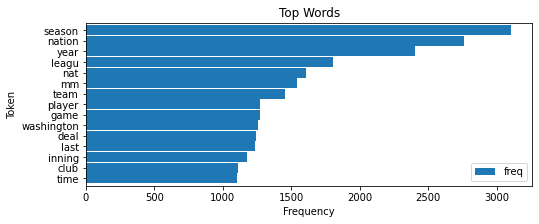

In [37]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# San Diego Padres Data Collection and Cleaning

In [38]:
#URL of the website to scrape
url = "https://www.mlbtraderumors.com/san-diego-padres?show=all"
file_path = "C:/Users/andre/OneDrive/Project/mlbtraderumors_san_diego_padres_articles1.txt"

#Scrape the website, write the scraped text to a file, and get the head of the DataFrame
sd_df = scrape_website(url, file_path)
sd_df.head()

,Title,Author,Date,Content
0,Padres Select Matt Waldron,Anthony Franco,"June 24, 2023",TODAY: The Padres have officially announced their selection of Waldron’s contract. To make room ...
1,Michael Wacha To Skip Start Due To Shoulder Fatigue,Mark Polishuk,"June 24, 2023","Knuckleballer Matt Waldron will start today’s game for the Padres, as Michael Wacha (the origina..."
2,A’s Claim Angel Felipe,Steve Adams,"June 21, 2023","The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann..."
3,Padres Designate Nabil Crismatt For Assignment,Darragh McDonald,"June 20, 2023","The Padres announced that right-hander Seth Lugo has been reinstated from the injured list, with..."
4,Jose Iglesias Opts Out Of Contract With Padres,Anthony Franco,"June 19, 2023","Veteran infielder José Iglesias has opted out of his minor league deal with the Padres, reports ..."


In [39]:
#Change the Data column to a datetime object:
sd_df['Date'] = pd.to_datetime(sd_df['Date'], format="%B %d, %Y", errors= 'coerce')

In [40]:
sd_df.dtypes

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object

In [41]:
#Check for missing values
sd_df.isna().sum()

Title       0
Author      0
Date       30
Content     0
dtype: int64

In [42]:
len(sd_df)

1030

In [43]:
sd_df = sd_df.dropna()
sd_df

,Title,Author,Date,Content
0,Padres Select Matt Waldron,Anthony Franco,2023-06-24,TODAY: The Padres have officially announced their selection of Waldron’s contract. To make room ...
1,Michael Wacha To Skip Start Due To Shoulder Fatigue,Mark Polishuk,2023-06-24,"Knuckleballer Matt Waldron will start today’s game for the Padres, as Michael Wacha (the origina..."
2,A’s Claim Angel Felipe,Steve Adams,2023-06-21,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann..."
3,Padres Designate Nabil Crismatt For Assignment,Darragh McDonald,2023-06-20,"The Padres announced that right-hander Seth Lugo has been reinstated from the injured list, with..."
4,Jose Iglesias Opts Out Of Contract With Padres,Anthony Franco,2023-06-19,"Veteran infielder José Iglesias has opted out of his minor league deal with the Padres, reports ..."
...,...,...,...,...
995,Latest On Garrett Richards,Connor Byrne,2019-09-11,"Having scored a 10-year, $300MM contract, Manny Machado was easily the Padres’ biggest free-agen..."
996,Padres Unsure If Hunter Renfroe Will Play Again This Year,Connor Byrne,2019-09-10,Padres manager Andy Green isn’t willing to guarantee that banged up outfielder Hunter Renfroe wi...
997,Hunter Renfroe’s Second-Half Decline,Connor Byrne,2019-09-10,"Just a couple months ago, Padres outfielder Hunter Renfroe looked like a legitimate breakout pla..."
998,Padres Face Outfield Uncertainty,Jeff Todd,2019-09-10,The Padres continue to feature numerous possibilities and numerous questions in their outfield m...


In [44]:
len(sd_df)

1000

## Import data on the San Diego Padres from baseball-reference.com.

https://www.baseball-reference.com/teams/SDP/attend.shtml


In [45]:
#URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/SDP/attend.shtml"

#Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

#Select the table of interest (index 0 in this case)
table = tables[0]

#Save the DataFrame as a CSV file
file_path = "C:/Users/andre/OneDrive/Project/MLB_data/padres_statistics.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)

Data saved to C:/Users/andre/OneDrive/Project/MLB_data/padres_statistics.csv


In [46]:
path = "C:/Users/andre/OneDrive/Project/MLB_data/"

padres_df = pd.DataFrame(pd.read_csv(path + 'padres_statistics.csv'))
padres_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,San Diego Padres,NL West,37,40,4,NaN,1635354.0,39887.0,2nd of 15,"$234,100,139",93,93,Petco Park
1,2022,San Diego Padres,NL West,89,73,2,Lost NLCS (4-1),2987470.0,36882.0,4th of 15,"$173,600,824",93,93,Petco Park
2,2021,San Diego Padres,NL West,79,83,3,NaN,2191950.0,27061.0,3rd of 15,"$151,984,286",92,92,Petco Park
3,2020,San Diego Padres,NL West,37,23,2,Lost NLDS (3-0),NaN,NaN,12th of 15,"$141,953,667",93,93,Petco Park
4,2019,San Diego Padres,NL West,70,92,5,NaN,2396399.0,29585.0,10th of 15,"$90,260,767",95,94,Petco Park


In [47]:
padres_df= padres_df[padres_df['Year'] > 2004]
padres_df

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,San Diego Padres,NL West,37,40,4,NaN,1635354.0,39887.0,2nd of 15,"$234,100,139",93,93,Petco Park
1,2022,San Diego Padres,NL West,89,73,2,Lost NLCS (4-1),2987470.0,36882.0,4th of 15,"$173,600,824",93,93,Petco Park
2,2021,San Diego Padres,NL West,79,83,3,NaN,2191950.0,27061.0,3rd of 15,"$151,984,286",92,92,Petco Park
3,2020,San Diego Padres,NL West,37,23,2,Lost NLDS (3-0),NaN,NaN,12th of 15,"$141,953,667",93,93,Petco Park
4,2019,San Diego Padres,NL West,70,92,5,NaN,2396399.0,29585.0,10th of 15,"$90,260,767",95,94,Petco Park
5,2018,San Diego Padres,NL West,66,96,5,NaN,2168536.0,26772.0,11th of 15,"$93,821,067",95,93,Petco Park
6,2017,San Diego Padres,NL West,71,91,4,NaN,2138491.0,26401.0,10th of 15,"$49,248,767",97,95,Petco Park
7,2016,San Diego Padres,NL West,68,94,5,NaN,2351422.0,29030.0,8th of 15,"$50,656,166",95,95,Petco Park
8,2015,San Diego Padres,NL West,74,88,4,NaN,2459752.0,30367.0,10th of 15,"$125,203,700",95,95,Petco Park
9,2014,San Diego Padres,NL West,77,85,3,NaN,2195373.0,27103.0,12th of 15,"$76,662,100",92,92,Petco Park


In [48]:
#Remove the dollar and comma signs from the 'Estimated Payroll' column:
padres_df['Est. Payroll'] = padres_df['Est. Payroll'].replace({'\$':''}, regex = True)
padres_df['Est. Payroll'] = padres_df['Est. Payroll'].replace({'\,':''}, regex = True)
padres_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,San Diego Padres,NL West,37,40,4,NaN,1635354.0,39887.0,2nd of 15,234100139,93,93,Petco Park
1,2022,San Diego Padres,NL West,89,73,2,Lost NLCS (4-1),2987470.0,36882.0,4th of 15,173600824,93,93,Petco Park
2,2021,San Diego Padres,NL West,79,83,3,NaN,2191950.0,27061.0,3rd of 15,151984286,92,92,Petco Park
3,2020,San Diego Padres,NL West,37,23,2,Lost NLDS (3-0),NaN,NaN,12th of 15,141953667,93,93,Petco Park
4,2019,San Diego Padres,NL West,70,92,5,NaN,2396399.0,29585.0,10th of 15,90260767,95,94,Petco Park


In [49]:
padres_df['Est. Payroll'] = padres_df['Est. Payroll'].astype(float)
padres_df.dtypes

Year              int64
Tm               object
Lg               object
W                 int64
L                 int64
Finish            int64
Playoffs         object
Attendance      float64
Attend/G        float64
Rank             object
Est. Payroll    float64
PPF               int64
BPF               int64
Stadium          object
dtype: object

### Create Binary feature that defines a successful year as wins greater than or equal to 50% of total games played

In [50]:
#Add a column to define a binary output that has a 1 if the team has a winning record for the year, and 0 if they do not
padres_df['success'] = (padres_df['W'] / (padres_df['W'] + padres_df['L']) >= 0.5).astype(int)
padres_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium,success
0,2023,San Diego Padres,NL West,37,40,4,NaN,1635354.0,39887.0,2nd of 15,234100139.0,93,93,Petco Park,0
1,2022,San Diego Padres,NL West,89,73,2,Lost NLCS (4-1),2987470.0,36882.0,4th of 15,173600824.0,93,93,Petco Park,1
2,2021,San Diego Padres,NL West,79,83,3,NaN,2191950.0,27061.0,3rd of 15,151984286.0,92,92,Petco Park,0
3,2020,San Diego Padres,NL West,37,23,2,Lost NLDS (3-0),NaN,NaN,12th of 15,141953667.0,93,93,Petco Park,1
4,2019,San Diego Padres,NL West,70,92,5,NaN,2396399.0,29585.0,10th of 15,90260767.0,95,94,Petco Park,0


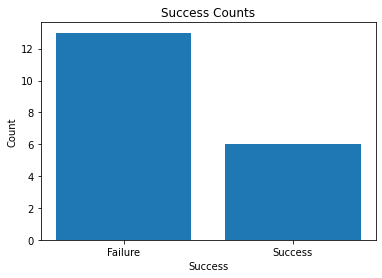

In [51]:
#Count the number of successes and failures
success_counts = padres_df['success'].value_counts()

#Create a bar plot
plt.bar(success_counts.index, success_counts.values)
plt.xticks(success_counts.index, ['Failure', 'Success'])
plt.xlabel('Success')
plt.ylabel('Count')
plt.title('Success Counts')

#Display the plot
plt.show()

In [52]:
padres_df.describe()

,Year,W,L,Finish,Attendance,Attend/G,Est. Payroll,PPF,BPF,success
count,19.000000,19.000000,19.000000,19.000000,1.800000e+01,18.000000,1.900000e+01,19.000000,19.000000,19.000000
mean,2014.000000,72.526316,79.684211,3.421053,2.319817e+06,29733.944444,8.992487e+07,92.368421,92.105263,0.315789
std,5.627314,14.833777,18.929849,1.346427,3.402212e+05,4428.852945,5.233473e+07,2.290331,2.024701,0.477567
min,2005.000000,37.000000,23.000000,1.000000,1.635354e+06,23699.000000,3.779930e+07,88.000000,87.000000,0.000000
25%,2009.500000,69.000000,74.000000,2.500000,2.139623e+06,26530.000000,5.322445e+07,91.000000,91.000000,0.000000
50%,2014.000000,75.000000,86.000000,4.000000,2.193662e+06,28066.500000,6.989614e+07,92.000000,92.000000,0.000000
75%,2018.500000,80.500000,91.000000,4.500000,2.451698e+06,32219.500000,1.095124e+08,94.000000,93.000000,1.000000
max,2023.000000,90.000000,99.000000,5.000000,2.987470e+06,39887.000000,2.341001e+08,97.000000,95.000000,1.000000


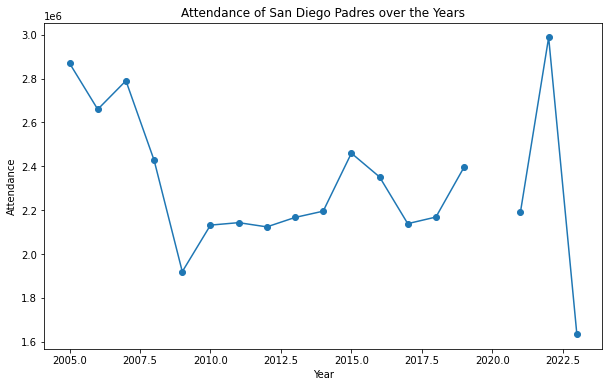

In [53]:
#Plotting the data
#Convert columns to numpy arrays
year = np.array(padres_df['Year'])
attendance = np.array(padres_df['Attendance'])

plt.figure(figsize=(10, 6))

#Plotting Attendance over the years
plt.plot(year, attendance, marker='o')
plt.xlabel('Year')
plt.ylabel('Attendance')
plt.title('Attendance of San Diego Padres over the Years')

#Display the plot
plt.show()

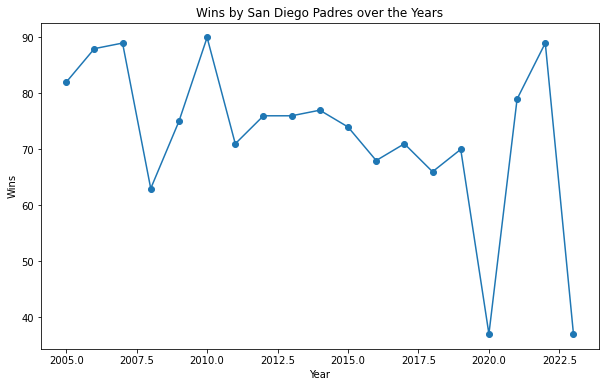

In [54]:
#Plotting Wins over the years
year = np.array(padres_df['Year'])
wins = np.array(padres_df['W'])

plt.figure(figsize= (10,6))

#Plotting Attendance over the years
plt.plot(year, wins, marker='o')
plt.xlabel('Year')
plt.ylabel('Wins')
plt.title('Wins by San Diego Padres over the Years')

#Display the plot
plt.show()

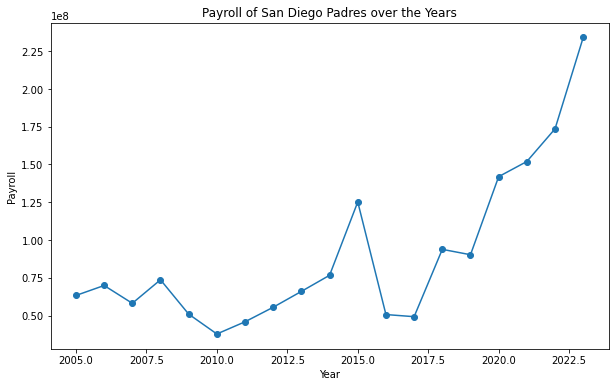

In [55]:
#Plotting Payroll over the years
#Convert columns to numpy arrays
year = np.array(padres_df['Year'])
payroll = np.array(padres_df['Est. Payroll'])

plt.figure(figsize= (10,6))

#Plotting Attendance over the years
plt.plot(year, payroll, marker='o')
plt.xlabel('Year')
plt.ylabel('Payroll')
plt.title('Payroll of San Diego Padres over the Years')

#Display the plot
plt.show()

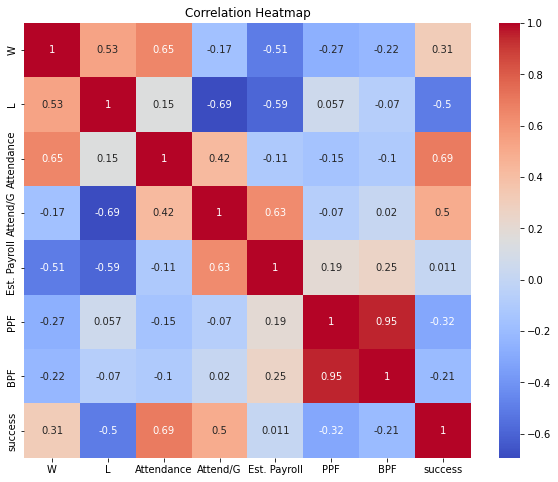

In [56]:
#Select numeric columns for correlation analysis
numeric_cols = ['W', 'L', 'Attendance', 'Attend/G', 'Est. Payroll', 'PPF', 'BPF', 'success']
numeric_df = padres_df[numeric_cols]

#Correlation matrix
correlation = numeric_df.corr()

#Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

#Display the plot
plt.show()

### Add column to analyze whether blog post occurred in a successful year or not.

In [57]:
#Extract the year from the "Date" column in df DataFrame
sd_df['Year'] = pd.to_datetime(sd_df['Date']).dt.year

#Merge df and athletics_df DataFrames on the "Year" column
merged_sd_df = pd.merge(sd_df, padres_df[['Year', 'success']], on='Year', how='left')

#Add a new column 'Year_Successful' based on 'success' column
merged_sd_df['Year_Successful'] = merged_sd_df['success'].fillna(0).astype(int)

merged_sd_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful
0,Padres Select Matt Waldron,Anthony Franco,2023-06-24,TODAY: The Padres have officially announced their selection of Waldron’s contract. To make room ...,2023,0,0
1,Michael Wacha To Skip Start Due To Shoulder Fatigue,Mark Polishuk,2023-06-24,"Knuckleballer Matt Waldron will start today’s game for the Padres, as Michael Wacha (the origina...",2023,0,0
2,A’s Claim Angel Felipe,Steve Adams,2023-06-21,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann...",2023,0,0
3,Padres Designate Nabil Crismatt For Assignment,Darragh McDonald,2023-06-20,"The Padres announced that right-hander Seth Lugo has been reinstated from the injured list, with...",2023,0,0
4,Jose Iglesias Opts Out Of Contract With Padres,Anthony Franco,2023-06-19,"Veteran infielder José Iglesias has opted out of his minor league deal with the Padres, reports ...",2023,0,0


In [58]:
len(merged_sd_df)

1000

## Cleaning the Padres' Data

In [59]:
#Identify any noise in the data
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

In [60]:
merged_sd_df['Content'].apply

<bound method Series.apply of 0      TODAY: The Padres have officially announced their selection of Waldron’s contract. To make room ...
1      Knuckleballer Matt Waldron will start today’s game for the Padres, as Michael Wacha (the origina...
2      The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann...
3      The Padres announced that right-hander Seth Lugo has been reinstated from the injured list, with...
4      Veteran infielder José Iglesias has opted out of his minor league deal with the Padres, reports ...
                                                      ...                                                 
995    Having scored a 10-year, $300MM contract, Manny Machado was easily the Padres’ biggest free-agen...
996    Padres manager Andy Green isn’t willing to guarantee that banged up outfielder Hunter Renfroe wi...
997    Just a couple months ago, Padres outfielder Hunter Renfroe looked like a legitimate breakout pla...
998    

In [61]:
pd.options.display.max_colwidth = 100 ###
#Add new column to data frame
merged_sd_df['impurity'] = merged_sd_df['Content'].apply(impurity, min_len=10)

#Get the top 3 records
merged_sd_df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
61,"Jake Cronenworth signed a seven-year, $80MM extension with the Padres, so what does that mean fo...",0.009479
131,"Major League Baseball’s international signing period for 2023 has officially opened up today, wi...",0.005563
842,What is the role of the Players’ Union in the Astros’ sign-stealing scandal? Why are the Padres ...,0.003484


The above shows the highest impurity levels for the Padres' data set. Note, these are extremely low...well below 1% of all characters in each blog post are suspicious.

## Character Normalization and Tokenization

In [62]:
#Example function to normalize the text in the "Contents" column
def normalize_text(text):
    #Lowercase the text
    text = text.lower()

    #Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    #Remove special characters and digits
    text = re.sub(r"[^a-zA-Z]", " ", text)

    #Tokenize the text
    tokens = word_tokenize(text)

    #Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    #Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

#Apply normalization to the "Contents" column
merged_sd_df["Contents_Normalized"] = merged_sd_df["Content"].apply(normalize_text)

#Print the head of the DataFrame with the normalized contents
merged_sd_df[["Content", "Contents_Normalized"]].head()
 	

,Content,Contents_Normalized
0,TODAY: The Padres have officially announced their selection of Waldron’s contract. To make room ...,"[today, padr, offici, announc, select, waldron, contract, make, room, waldron, activ, roster, le..."
1,"Knuckleballer Matt Waldron will start today’s game for the Padres, as Michael Wacha (the origina...","[knucklebal, matt, waldron, start, today, game, padr, michael, wacha, origin, schedul, starter, ..."
2,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann...","[athlet, claim, righthand, angel, felip, waiver, padr, per, team, announc, felip, option, triple..."
3,"The Padres announced that right-hander Seth Lugo has been reinstated from the injured list, with...","[padr, announc, righthand, seth, lugo, reinstat, injur, list, fellow, righti, nabil, crismatt, d..."
4,"Veteran infielder José Iglesias has opted out of his minor league deal with the Padres, reports ...","[veteran, infield, jo, iglesia, opt, minor, leagu, deal, padr, report, mark, feinsand, mlbcom, t..."


In [63]:
merged_sd_df['length'] = merged_sd_df['Contents_Normalized'].str.len()
merged_sd_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length
0,Padres Select Matt Waldron,Anthony Franco,2023-06-24,TODAY: The Padres have officially announced their selection of Waldron’s contract. To make room ...,2023,0,0,0.0,"[today, padr, offici, announc, select, waldron, contract, make, room, waldron, activ, roster, le...",222
1,Michael Wacha To Skip Start Due To Shoulder Fatigue,Mark Polishuk,2023-06-24,"Knuckleballer Matt Waldron will start today’s game for the Padres, as Michael Wacha (the origina...",2023,0,0,0.0,"[knucklebal, matt, waldron, start, today, game, padr, michael, wacha, origin, schedul, starter, ...",91
2,A’s Claim Angel Felipe,Steve Adams,2023-06-21,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann...",2023,0,0,0.0,"[athlet, claim, righthand, angel, felip, waiver, padr, per, team, announc, felip, option, triple...",182
3,Padres Designate Nabil Crismatt For Assignment,Darragh McDonald,2023-06-20,"The Padres announced that right-hander Seth Lugo has been reinstated from the injured list, with...",2023,0,0,0.0,"[padr, announc, righthand, seth, lugo, reinstat, injur, list, fellow, righti, nabil, crismatt, d...",147
4,Jose Iglesias Opts Out Of Contract With Padres,Anthony Franco,2023-06-19,"Veteran infielder José Iglesias has opted out of his minor league deal with the Padres, reports ...",2023,0,0,0.0,"[veteran, infield, jo, iglesia, opt, minor, leagu, deal, padr, report, mark, feinsand, mlbcom, t...",181


## Analyze descriptive statistics for text in dataframe.

<Axes: >

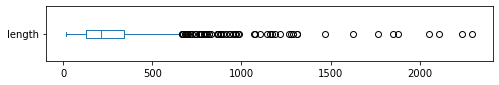

In [64]:
merged_sd_df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: >

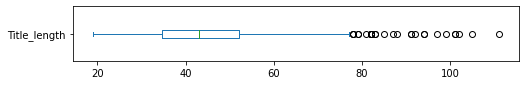

In [65]:
merged_sd_df['Title_length'] = merged_sd_df['Title'].str.len()
merged_sd_df['Title_length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: ylabel='Frequency'>

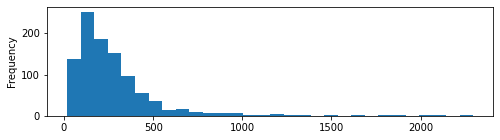

In [66]:
merged_sd_df['length'].plot(kind='hist', bins=30, figsize=(8,2))

<Axes: title={'center': 'Avg. Post Length'}, xlabel='Month'>

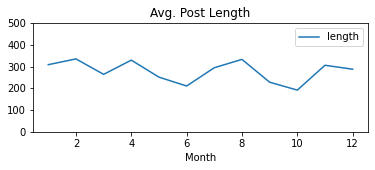

In [67]:
#Extract the month from the date and create a new column
merged_sd_df['Month'] = merged_sd_df['Date'].dt.month

#Plot the average post length
merged_sd_df.groupby('Month').agg({'length': 'mean'}) \
  .plot(title="Avg. Post Length", ylim=(0,500), figsize=(6,2))

In [68]:
def count_words(df, column='Contents_Normalized', preprocess=None, min_freq=2):

    #Process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    #Create counter and run through all data
    counter = Counter()
    tqdm.pandas() #initialize tqdm for progress bar
    df[column].apply(update)

    #Transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [69]:
freq_df = count_words(merged_sd_df)
freq_df.head(5)

,freq
token,
padr,3770
season,3483
year,2701
mm,2362
leagu,1831


In [70]:
#How many tokens are in the df?
len(freq_df)

6520

In [71]:
#Top words with 10+ characters
count_words(merged_sd_df, column='Content', 
            preprocess=lambda Content: re.findall(r"\w{10,}", Content)).head(5)

,freq
token,
appearances,645
outfielder,379
organization,319
arbitration,258
assignment,195


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

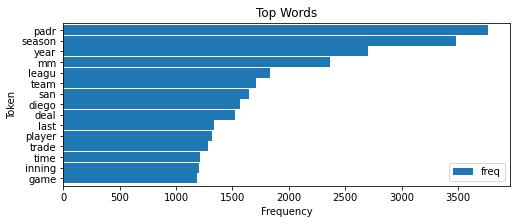

In [72]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# Oakland Athletics Data Collection and Cleaning

In [73]:
#URL of the website to scrape
url = "https://www.mlbtraderumors.com/oakland-athletics?show=all"
file_path = "C:/Users/andre/OneDrive/Project/mlbtraderumors_oakland_athletics_articles1.txt"

#Scrape the website, write the scraped text to a file, and get the head of the DataFrame
oa_df = scrape_website(url, file_path)
oa_df.head()

,Title,Author,Date,Content
0,Athletics Place Ramón Laureano On IL With Hand Fracture,Darragh McDonald,"June 23, 2023",2:55pm: Martin Gallegos of MLB.com relays word from the A’s training staff that this injury is t...
1,A’s Preparing Application To MLB For Relocation,Anthony Franco,"June 21, 2023",The Athletics have begun the process to officially apply to Major League Baseball for relocation...
2,A’s Claim Angel Felipe,Steve Adams,"June 21, 2023","The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann..."
3,Athletics Select Yacksel Ríos,Darragh McDonald,"June 20, 2023",The Athletics announced that they have selected the contract of right-hander Yacksel Ríos. Fello...
4,Dick Hall Passes Away,Darragh McDonald,"June 19, 2023",The Orioles have announced that former major leaguer Dick Hall has passed away. He was 92 years ...


In [74]:
#Change the Data column to a datetime object:
oa_df['Date'] = pd.to_datetime(oa_df['Date'], format="%B %d, %Y", errors= 'coerce')

In [75]:
oa_df.dtypes

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object

In [76]:
#Check for missing values
oa_df.isna().sum()

Title       0
Author      0
Date       30
Content     0
dtype: int64

In [77]:
len(oa_df)

1030

In [78]:
oa_df = oa_df.dropna()
oa_df

,Title,Author,Date,Content
0,Athletics Place Ramón Laureano On IL With Hand Fracture,Darragh McDonald,2023-06-23,2:55pm: Martin Gallegos of MLB.com relays word from the A’s training staff that this injury is t...
1,A’s Preparing Application To MLB For Relocation,Anthony Franco,2023-06-21,The Athletics have begun the process to officially apply to Major League Baseball for relocation...
2,A’s Claim Angel Felipe,Steve Adams,2023-06-21,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann..."
3,Athletics Select Yacksel Ríos,Darragh McDonald,2023-06-20,The Athletics announced that they have selected the contract of right-hander Yacksel Ríos. Fello...
4,Dick Hall Passes Away,Darragh McDonald,2023-06-19,The Orioles have announced that former major leaguer Dick Hall has passed away. He was 92 years ...
...,...,...,...,...
995,"Athletics Outright Hatcher, Smolinski, Kiekhefer",Steve Adams,2018-10-15,"5:29pm: Kiekhefer has indeed elected free agency, MLBTR has learned.\n2:37pm: The A’s have now a..."
996,Players Electing Free Agency,Jeff Todd,2018-10-08,"Quite a few players will hit the open market this fall, and they’ll do so by way of varying mech..."
997,"Forst: A's Expect Luzardo To Be ""A Factor"" Next Year",Steve Adams,2018-10-08,While some Athletics fans were hoping for a look at top pitching prospect Jesus Luardo late in t...
998,"A’s Notes: Davis, Melvin, Lucroy, Lowrie, Kelley",Mark Polishuk,2018-10-05,"After falling short in the AL wild card game, the Athletics are looking ahead to what they hope ..."


In [79]:
len(oa_df)

1000

## Import data on the Oakland Athletics from baseball-reference.com

https://www.baseball-reference.com/teams/OAK/attend.shtml

In [80]:
#URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/OAK/attend.shtml"

#Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

#Select the table of interest (index 0 in this case)
table = tables[0]

#Save the DataFrame as a CSV file
file_path = "C:/Users/andre/OneDrive/Project/MLB_data/athletics_statistics.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)

Data saved to C:/Users/andre/OneDrive/Project/MLB_data/athletics_statistics.csv


In [81]:
path = "C:/Users/andre/OneDrive/Project/MLB_data/"

athletics_df = pd.DataFrame(pd.read_csv(path + 'athletics_statistics.csv'))
athletics_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Oakland Athletics,AL West,20,59,5,NaN,368146.0,9688.0,15th of 15,"$51,230,000",95,93,Oakland Coliseum
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,"$50,248,334",95,93,RingCentral Coliseum
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,"$94,555,834",95,95,RingCentral Coliseum
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,"$85,683,333",94,96,Oakland-Alameda County Coliseum
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,"$102,935,833",93,94,Oakland-Alameda County Coliseum


In [82]:
athletics_df= athletics_df[athletics_df['Year'] > 2004]
athletics_df

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Oakland Athletics,AL West,20,59,5,NaN,368146.0,9688.0,15th of 15,"$51,230,000",95,93,Oakland Coliseum
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,"$50,248,334",95,93,RingCentral Coliseum
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,"$94,555,834",95,95,RingCentral Coliseum
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,"$85,683,333",94,96,Oakland-Alameda County Coliseum
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,"$102,935,833",93,94,Oakland-Alameda County Coliseum
5,2018,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1573616.0,19427.0,13th of 15,"$69,883,333",97,97,Oakland-Alameda County Coliseum
6,2017,Oakland Athletics,AL West,75,87,5,NaN,1475721.0,18219.0,14th of 15,"$51,560,000",95,95,Oakland-Alameda County Coliseum
7,2016,Oakland Athletics,AL West,69,93,5,NaN,1521506.0,18784.0,14th of 15,"$54,969,067",97,96,Oakland-Alameda County Coliseum
8,2015,Oakland Athletics,AL West,68,94,5,NaN,1768175.0,21829.0,12th of 15,"$64,016,001",97,97,O.co Coliseum
9,2014,Oakland Athletics,AL West,88,74,2,Lost ALWC (1-0),2003628.0,24736.0,10th of 15,"$89,160,900",97,98,O.co Coliseum


In [83]:
#Remove the dollar and comma signs from the 'Estimated Payroll' column:
athletics_df['Est. Payroll'] = athletics_df['Est. Payroll'].replace({'\$':''}, regex = True)
athletics_df['Est. Payroll'] = athletics_df['Est. Payroll'].replace({'\,':''}, regex = True)
athletics_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Oakland Athletics,AL West,20,59,5,NaN,368146.0,9688.0,15th of 15,51230000,95,93,Oakland Coliseum
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,50248334,95,93,RingCentral Coliseum
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,94555834,95,95,RingCentral Coliseum
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,85683333,94,96,Oakland-Alameda County Coliseum
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,102935833,93,94,Oakland-Alameda County Coliseum


In [84]:
athletics_df['Est. Payroll'] = athletics_df['Est. Payroll'].astype(float)
athletics_df.dtypes

Year              int64
Tm               object
Lg               object
W                 int64
L                 int64
Finish            int64
Playoffs         object
Attendance      float64
Attend/G        float64
Rank             object
Est. Payroll    float64
PPF               int64
BPF               int64
Stadium          object
dtype: object

## Create Binary feature that defines a successful year as wins greater than or equal to 50% of total games played

In [85]:
#Add a column to define a binary output that has a 1 if the team has a winning record for the year, and 0 if they do not
athletics_df['success'] = (athletics_df['W'] / (athletics_df['W'] + athletics_df['L']) >= 0.5).astype(int)
athletics_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium,success
0,2023,Oakland Athletics,AL West,20,59,5,NaN,368146.0,9688.0,15th of 15,51230000.0,95,93,Oakland Coliseum,0
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,50248334.0,95,93,RingCentral Coliseum,0
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,94555834.0,95,95,RingCentral Coliseum,1
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,85683333.0,94,96,Oakland-Alameda County Coliseum,1
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,102935833.0,93,94,Oakland-Alameda County Coliseum,1


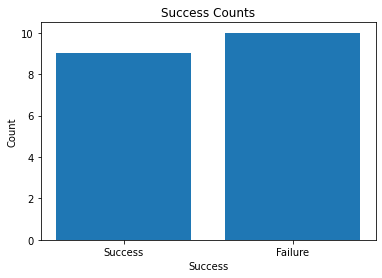

In [86]:
#Count the number of successes and failures
success_counts = athletics_df['success'].value_counts()

#Create a bar plot
plt.bar(success_counts.index, success_counts.values)
plt.xticks(success_counts.index, ['Failure', 'Success'])
plt.xlabel('Success')
plt.ylabel('Count')
plt.title('Success Counts')

#Display the plot
plt.show()

In [87]:
athletics_df.describe()

,Year,W,L,Finish,Attendance,Attend/G,Est. Payroll,PPF,BPF,success
count,19.000000,19.000000,19.000000,19.000000,1.800000e+01,18.000000,1.900000e+01,19.000000,19.000000,19.000000
mean,2014.000000,76.210526,76.000000,2.894737,1.518666e+06,19041.388889,6.754905e+07,96.157895,96.157895,0.526316
std,5.627314,20.302104,17.249799,1.523692,4.682565e+05,5114.775012,1.597226e+07,1.893356,2.061907,0.512989
min,2005.000000,20.000000,24.000000,1.000000,3.681460e+05,8660.000000,4.796713e+07,93.000000,93.000000,0.000000
25%,2009.500000,71.500000,67.000000,2.000000,1.432724e+06,17688.000000,5.519741e+07,95.000000,94.500000,0.000000
50%,2014.000000,76.000000,76.000000,3.000000,1.619436e+06,19993.000000,6.484308e+07,97.000000,96.000000,1.000000
75%,2018.500000,90.500000,87.000000,4.500000,1.799020e+06,22210.000000,7.462514e+07,97.000000,98.000000,1.000000
max,2023.000000,97.000000,102.000000,5.000000,2.109118e+06,26038.000000,1.029358e+08,100.000000,100.000000,1.000000


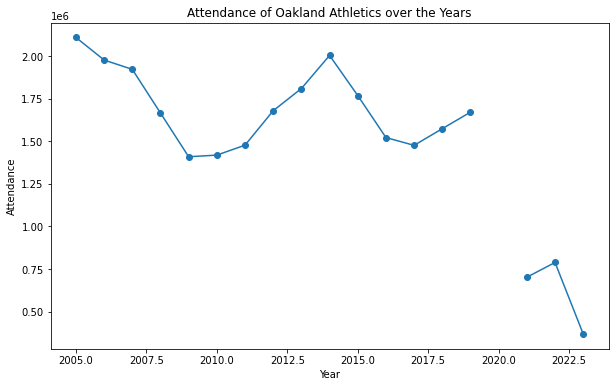

In [88]:
#Plotting the data
#Convert columns to numpy arrays
year = np.array(athletics_df['Year'])
attendance = np.array(athletics_df['Attendance'])

plt.figure(figsize=(10, 6))

#Plotting Attendance over the years
plt.plot(year, attendance, marker='o')
plt.xlabel('Year')
plt.ylabel('Attendance')
plt.title('Attendance of Oakland Athletics over the Years')

#Display the plot
plt.show()

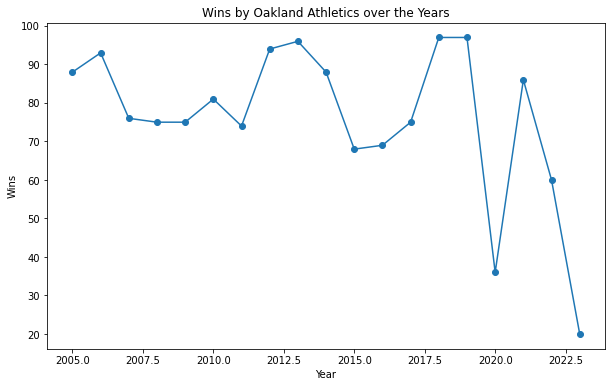

In [89]:
#Plotting Wins over the years
year = np.array(athletics_df['Year'])
wins = np.array(athletics_df['W'])

plt.figure(figsize= (10,6))

#Plotting Attendance over the years
plt.plot(year, wins, marker='o')
plt.xlabel('Year')
plt.ylabel('Wins')
plt.title('Wins by Oakland Athletics over the Years')

#Display the plot
plt.show()

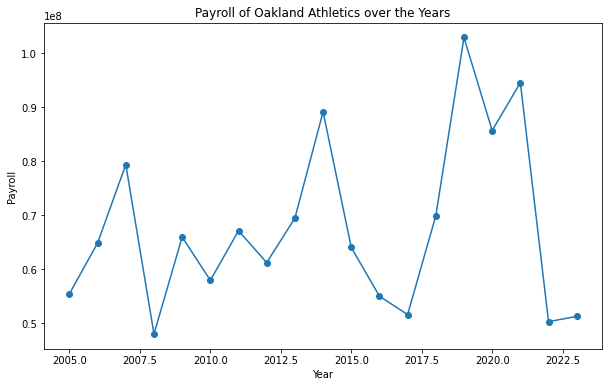

In [90]:
#Plotting Payroll over the years
#Convert columns to numpy arrays
year = np.array(athletics_df['Year'])
payroll = np.array(athletics_df['Est. Payroll'])

plt.figure(figsize= (10,6))

#Plotting Attendance over the years
plt.plot(year, payroll, marker='o')
plt.xlabel('Year')
plt.ylabel('Payroll')
plt.title('Payroll of Oakland Athletics over the Years')

#Display the plot
plt.show()

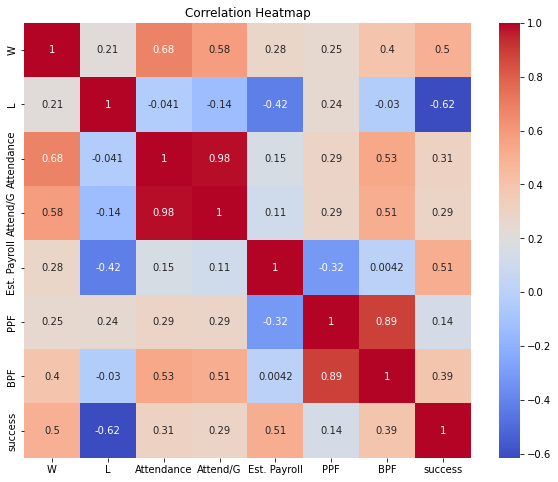

In [91]:
#Select numeric columns for correlation analysis
numeric_cols = ['W', 'L', 'Attendance', 'Attend/G', 'Est. Payroll', 'PPF', 'BPF', 'success']
numeric_df = athletics_df[numeric_cols]

#Correlation matrix
correlation = numeric_df.corr()

#Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

#Display the plot
plt.show()

#### Add column to analyze whether blog post occurred in a successful year or not.

In [92]:
#Extract the year from the "Date" column in df DataFrame
oa_df['Year'] = pd.to_datetime(oa_df['Date']).dt.year

#Merge df and athletics_df DataFrames on the "Year" column
merged_oa_df = pd.merge(oa_df, athletics_df[['Year', 'success']], on='Year', how='left')

#Add a new column 'Year_Successful' based on 'success' column
merged_oa_df['Year_Successful'] = merged_oa_df['success'].fillna(0).astype(int)

merged_oa_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful
0,Athletics Place Ramón Laureano On IL With Hand Fracture,Darragh McDonald,2023-06-23,2:55pm: Martin Gallegos of MLB.com relays word from the A’s training staff that this injury is t...,2023,0,0
1,A’s Preparing Application To MLB For Relocation,Anthony Franco,2023-06-21,The Athletics have begun the process to officially apply to Major League Baseball for relocation...,2023,0,0
2,A’s Claim Angel Felipe,Steve Adams,2023-06-21,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann...",2023,0,0
3,Athletics Select Yacksel Ríos,Darragh McDonald,2023-06-20,The Athletics announced that they have selected the contract of right-hander Yacksel Ríos. Fello...,2023,0,0
4,Dick Hall Passes Away,Darragh McDonald,2023-06-19,The Orioles have announced that former major leaguer Dick Hall has passed away. He was 92 years ...,2023,0,0


In [93]:
len(merged_oa_df)

1000

## Cleaning the Athletics' Data

In [94]:
#Identify any noise in the data
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

In [95]:
merged_oa_df['Content'].apply

<bound method Series.apply of 0      2:55pm: Martin Gallegos of MLB.com relays word from the A’s training staff that this injury is t...
1      The Athletics have begun the process to officially apply to Major League Baseball for relocation...
2      The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann...
3      The Athletics announced that they have selected the contract of right-hander Yacksel Ríos. Fello...
4      The Orioles have announced that former major leaguer Dick Hall has passed away. He was 92 years ...
                                                      ...                                                 
995    5:29pm: Kiekhefer has indeed elected free agency, MLBTR has learned.\n2:37pm: The A’s have now a...
996    Quite a few players will hit the open market this fall, and they’ll do so by way of varying mech...
997    While some Athletics fans were hoping for a look at top pitching prospect Jesus Luardo late in t...
998    

In [96]:
pd.options.display.max_colwidth = 100 ###
#Add new column to data frame
merged_oa_df['impurity'] = merged_oa_df['Content'].apply(impurity, min_len=10)

#Get the top 3 records
merged_oa_df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
115,"Major League Baseball’s international signing period for 2023 has officially opened up today, wi...",0.005563
948,Left-handed pitching prospect Jesus Luzardo is drawing raves from both inside and outside the At...,0.004474
535,Kingston fit the mold of many of the Angels’ candidates — well-regarded younger executives who w...,0.003306


The above shows the highest impurity levels for the Athletics' data set. Note, these are extremely low...well below 1% of all characters in each blog post are suspicious.

## Character Normalization and Tokenization

In [97]:
#Example function to normalize the text in the "Contents" column
def normalize_text(text):
    #Lowercase the text
    text = text.lower()

    #Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    #Remove special characters and digits
    text = re.sub(r"[^a-zA-Z]", " ", text)

    #Tokenize the text
    tokens = word_tokenize(text)

    #Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    #Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

#Apply normalization to the "Contents" column
merged_oa_df["Contents_Normalized"] = merged_oa_df["Content"].apply(normalize_text)

#Print the head of the DataFrame with the normalized contents
merged_oa_df[["Content", "Contents_Normalized"]].head()
 	

,Content,Contents_Normalized
0,2:55pm: Martin Gallegos of MLB.com relays word from the A’s training staff that this injury is t...,"[pm, martin, gallego, mlbcom, relay, word, train, staff, injuri, result, laureano, get, hit, pit..."
1,The Athletics have begun the process to officially apply to Major League Baseball for relocation...,"[athlet, begun, process, offici, appli, major, leagu, basebal, reloc, write, mick, aker, la, veg..."
2,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann...","[athlet, claim, righthand, angel, felip, waiver, padr, per, team, announc, felip, option, triple..."
3,The Athletics announced that they have selected the contract of right-hander Yacksel Ríos. Fello...,"[athlet, announc, select, contract, righthand, yacksel, r, os, fellow, righti, chad, smith, opti..."
4,The Orioles have announced that former major leaguer Dick Hall has passed away. He was 92 years ...,"[oriol, announc, former, major, leaguer, dick, hall, pass, away, year, old, hall, underw, mani, ..."


In [98]:
merged_oa_df['length'] = merged_oa_df['Contents_Normalized'].str.len()
merged_oa_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length
0,Athletics Place Ramón Laureano On IL With Hand Fracture,Darragh McDonald,2023-06-23,2:55pm: Martin Gallegos of MLB.com relays word from the A’s training staff that this injury is t...,2023,0,0,0.0,"[pm, martin, gallego, mlbcom, relay, word, train, staff, injuri, result, laureano, get, hit, pit...",253
1,A’s Preparing Application To MLB For Relocation,Anthony Franco,2023-06-21,The Athletics have begun the process to officially apply to Major League Baseball for relocation...,2023,0,0,0.0,"[athlet, begun, process, offici, appli, major, leagu, basebal, reloc, write, mick, aker, la, veg...",134
2,A’s Claim Angel Felipe,Steve Adams,2023-06-21,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann...",2023,0,0,0.0,"[athlet, claim, righthand, angel, felip, waiver, padr, per, team, announc, felip, option, triple...",182
3,Athletics Select Yacksel Ríos,Darragh McDonald,2023-06-20,The Athletics announced that they have selected the contract of right-hander Yacksel Ríos. Fello...,2023,0,0,0.0,"[athlet, announc, select, contract, righthand, yacksel, r, os, fellow, righti, chad, smith, opti...",179
4,Dick Hall Passes Away,Darragh McDonald,2023-06-19,The Orioles have announced that former major leaguer Dick Hall has passed away. He was 92 years ...,2023,0,0,0.0,"[oriol, announc, former, major, leaguer, dick, hall, pass, away, year, old, hall, underw, mani, ...",173


## Analyze descriptive statistics for text in dataframe.

<Axes: >

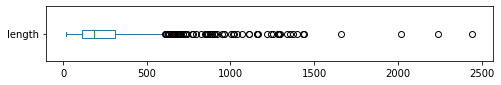

In [99]:
merged_oa_df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: >

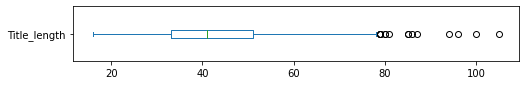

In [100]:
merged_oa_df['Title_length'] = merged_oa_df['Title'].str.len()
merged_oa_df['Title_length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: ylabel='Frequency'>

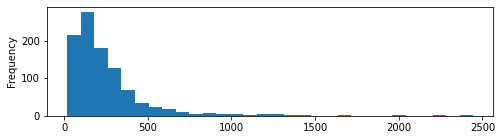

In [101]:
merged_oa_df['length'].plot(kind='hist', bins=30, figsize=(8,2))

<Axes: title={'center': 'Avg. Post Length'}, xlabel='Month'>

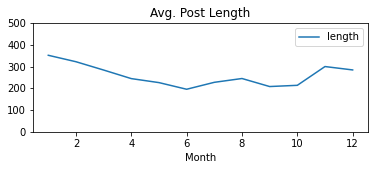

In [102]:
#Extract the month from the date and create a new column
merged_oa_df['Month'] = merged_oa_df['Date'].dt.month

#Plot the average post length
merged_oa_df.groupby('Month').agg({'length': 'mean'}) \
  .plot(title="Avg. Post Length", ylim=(0,500), figsize=(6,2))


In [103]:
def count_words(df, column='Contents_Normalized', preprocess=None, min_freq=2):

    #Process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    #Create counter and run through all data
    counter = Counter()
    tqdm.pandas() #initialize tqdm for progress bar
    df[column].apply(update)

    #Transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [104]:
freq_df = count_words(merged_oa_df)
freq_df.head(5)

,freq
token,
season,3187
year,2294
leagu,1839
mm,1596
oakland,1572


In [105]:
#How many tokens are in the df?
len(freq_df)

6653

In [106]:
#Top words with 10+ characters
count_words(merged_oa_df, column='Content', 
            preprocess=lambda Content: re.findall(r"\w{10,}", Content)).head(5)

,freq
token,
appearances,733
organization,374
arbitration,369
outfielder,318
assignment,272


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

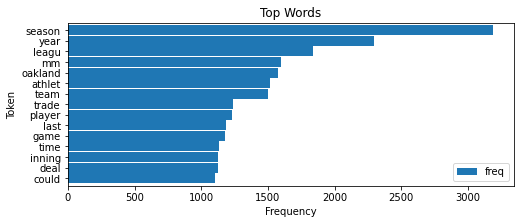

In [107]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# Chicago White Sox Data Collection and Cleaning

In [108]:
#URL of the website to scrape
url = "https://www.mlbtraderumors.com/chicago-white-sox?show=all"
file_path = "C:/Users/andre/OneDrive/Project/mlbtraderumors_chicago_white_sox_articles1.txt"

#Scrape the website, write the scraped text to a file, and get the head of the DataFrame
cws_df = scrape_website(url, file_path)
cws_df.head()

,Title,Author,Date,Content
0,"MLBTR Trade Rumors Podcast: Exciting Youth Movements in Cincinnati and Pittsburgh, Bad Central D...",Darragh McDonald,"June 21, 2023","The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w..."
1,"AL Central Notes: Buxton, Crochet, Tigers",Darragh McDonald,"June 21, 2023","Twins outfielder Byron Buxton has dealt with many injuries throughout his career, which has led ..."
2,White Sox Claim Touki Toussaint From Guardians,Darragh McDonald,"June 20, 2023","The White Sox have claimed right-hander Touki Toussaint off waivers from the Guardians, per anno..."
3,White Sox Recall Jose Rodriguez For MLB Debut,Anthony Franco,"June 19, 2023",The White Sox announced a handful of transactions before tonight’s series opener with the Ranger...
4,White Sox Place Mike Clevinger On Injured List,Anthony Franco,"June 16, 2023","The White Sox placed starter Mike Clevinger on the 15-day injured list, retroactive to June 15, ..."


In [109]:
#change the Date column to a datetime object:
cws_df['Date'] = pd.to_datetime(cws_df['Date'], format="%B %d, %Y", errors= 'coerce')

In [110]:
cws_df.dtypes

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object

In [111]:
cws_df.isna().sum()

Title       0
Author      0
Date       30
Content     0
dtype: int64

In [112]:
len(cws_df)

1030

In [113]:
cws_df = cws_df.dropna()
cws_df

,Title,Author,Date,Content
0,"MLBTR Trade Rumors Podcast: Exciting Youth Movements in Cincinnati and Pittsburgh, Bad Central D...",Darragh McDonald,2023-06-21,"The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w..."
1,"AL Central Notes: Buxton, Crochet, Tigers",Darragh McDonald,2023-06-21,"Twins outfielder Byron Buxton has dealt with many injuries throughout his career, which has led ..."
2,White Sox Claim Touki Toussaint From Guardians,Darragh McDonald,2023-06-20,"The White Sox have claimed right-hander Touki Toussaint off waivers from the Guardians, per anno..."
3,White Sox Recall Jose Rodriguez For MLB Debut,Anthony Franco,2023-06-19,The White Sox announced a handful of transactions before tonight’s series opener with the Ranger...
4,White Sox Place Mike Clevinger On Injured List,Anthony Franco,2023-06-16,"The White Sox placed starter Mike Clevinger on the 15-day injured list, retroactive to June 15, ..."
...,...,...,...,...
995,White Sox Outright Dustin Garneau,Connor Byrne,2018-10-02,"The White Sox have outrighted catcher Dustin Garneau to Triple-A Charlotte, Daryl Van Schouwen o..."
996,Rick Hahn On White Sox’ Offseason Plans,Jeff Todd,2018-09-27,White Sox GM Rick Hahn addressed the media yesterday regarding the state of his organization’s r...
997,Avisail Garcia To Undergo Knee Surgery,Jeff Todd,2018-09-25,"White Sox outfielder Avisail Garcia is set to undergo right knee surgery, he told reporters incl..."
998,"Past, Present & Future: American League Closer Turnover",Jason Martinez,2018-09-25,"By the end of the 2017 season, the list of pitchers closing out games for their respective teams..."


In [114]:
len(cws_df)

1000

## Import data on the Chicago White Sox from baseball-reference.com.

https://www.baseball-reference.com/teams/CHW/attend.shtml

In [115]:
#URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/CHW/attend.shtml"

#Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

#Select the table of interest (index 0 in this case)
table = tables[0]

#Save the DataFrame as a CSV file
file_path = "C:/Users/andre/OneDrive/Project/MLB_data/white_sox_statistics.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)

Data saved to C:/Users/andre/OneDrive/Project/MLB_data/white_sox_statistics.csv


In [116]:
path = "C:/Users/andre/OneDrive/Project/MLB_data/"

white_sox_df = pd.DataFrame(pd.read_csv(path + 'white_sox_statistics.csv'))
white_sox_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Chicago White Sox,AL Central,33,45,4,NaN,758109.0,19439.0,11th of 15,"$157,571,666",104,104,Guaranteed Rate Field
1,2022,Chicago White Sox,AL Central,81,81,2,NaN,2009359.0,24807.0,8th of 15,"$163,958,334",103,103,Guaranteed Rate Field
2,2021,Chicago White Sox,AL Central,93,69,1,Lost ALDS (3-1),1596385.0,19708.0,5th of 15,"$115,546,333",101,102,Guaranteed Rate Field
3,2020,Chicago White Sox,AL Central,35,25,3,Lost ALWC (2-1),NaN,NaN,3rd of 15,"$119,066,333",100,100,Guaranteed Rate Field
4,2019,Chicago White Sox,AL Central,72,89,3,NaN,1649775.0,20622.0,11th of 15,"$80,846,333",99,98,Guaranteed Rate Field


In [117]:
white_sox_df= white_sox_df[white_sox_df['Year'] > 2004]
white_sox_df

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Chicago White Sox,AL Central,33,45,4,NaN,758109.0,19439.0,11th of 15,"$157,571,666",104,104,Guaranteed Rate Field
1,2022,Chicago White Sox,AL Central,81,81,2,NaN,2009359.0,24807.0,8th of 15,"$163,958,334",103,103,Guaranteed Rate Field
2,2021,Chicago White Sox,AL Central,93,69,1,Lost ALDS (3-1),1596385.0,19708.0,5th of 15,"$115,546,333",101,102,Guaranteed Rate Field
3,2020,Chicago White Sox,AL Central,35,25,3,Lost ALWC (2-1),NaN,NaN,3rd of 15,"$119,066,333",100,100,Guaranteed Rate Field
4,2019,Chicago White Sox,AL Central,72,89,3,NaN,1649775.0,20622.0,11th of 15,"$80,846,333",99,98,Guaranteed Rate Field
5,2018,Chicago White Sox,AL Central,62,100,4,NaN,1608817.0,19862.0,12th of 15,"$75,092,000",99,98,Guaranteed Rate Field
6,2017,Chicago White Sox,AL Central,67,95,4,NaN,1629470.0,20117.0,13th of 15,"$97,842,000",98,97,Guaranteed Rate Field
7,2016,Chicago White Sox,AL Central,78,84,4,NaN,1746293.0,21559.0,12th of 15,"$113,416,000",96,96,U.S. Cellular Field
8,2015,Chicago White Sox,AL Central,76,86,4,NaN,1755810.0,21677.0,13th of 15,"$112,889,700",97,96,U.S. Cellular Field
9,2014,Chicago White Sox,AL Central,73,89,4,NaN,1650821.0,20381.0,13th of 15,"$87,475,500",98,97,U.S. Cellular Field


In [118]:
#Remove the dollar sign from the 'Estimated Payroll' column:
white_sox_df['Est. Payroll'] = white_sox_df['Est. Payroll'].replace({'\$':''}, regex = True)
white_sox_df['Est. Payroll'] = white_sox_df['Est. Payroll'].replace({'\,':''}, regex = True)
white_sox_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Chicago White Sox,AL Central,33,45,4,NaN,758109.0,19439.0,11th of 15,157571666,104,104,Guaranteed Rate Field
1,2022,Chicago White Sox,AL Central,81,81,2,NaN,2009359.0,24807.0,8th of 15,163958334,103,103,Guaranteed Rate Field
2,2021,Chicago White Sox,AL Central,93,69,1,Lost ALDS (3-1),1596385.0,19708.0,5th of 15,115546333,101,102,Guaranteed Rate Field
3,2020,Chicago White Sox,AL Central,35,25,3,Lost ALWC (2-1),NaN,NaN,3rd of 15,119066333,100,100,Guaranteed Rate Field
4,2019,Chicago White Sox,AL Central,72,89,3,NaN,1649775.0,20622.0,11th of 15,80846333,99,98,Guaranteed Rate Field


In [119]:
white_sox_df['Est. Payroll'] = white_sox_df['Est. Payroll'].astype(float)
white_sox_df.dtypes

Year              int64
Tm               object
Lg               object
W                 int64
L                 int64
Finish            int64
Playoffs         object
Attendance      float64
Attend/G        float64
Rank             object
Est. Payroll    float64
PPF               int64
BPF               int64
Stadium          object
dtype: object

### Create Binary feature that defines a successful year as wins greater than or equal to 50% of total games played

In [120]:
#Add a column to define a binary output that has a 1 if the team has a winning record for the year, and 0 if they do not
white_sox_df['success'] = (white_sox_df['W'] / (white_sox_df['W'] + white_sox_df['L']) >= 0.5).astype(int)
white_sox_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium,success
0,2023,Chicago White Sox,AL Central,33,45,4,NaN,758109.0,19439.0,11th of 15,157571666.0,104,104,Guaranteed Rate Field,0
1,2022,Chicago White Sox,AL Central,81,81,2,NaN,2009359.0,24807.0,8th of 15,163958334.0,103,103,Guaranteed Rate Field,1
2,2021,Chicago White Sox,AL Central,93,69,1,Lost ALDS (3-1),1596385.0,19708.0,5th of 15,115546333.0,101,102,Guaranteed Rate Field,1
3,2020,Chicago White Sox,AL Central,35,25,3,Lost ALWC (2-1),NaN,NaN,3rd of 15,119066333.0,100,100,Guaranteed Rate Field,1
4,2019,Chicago White Sox,AL Central,72,89,3,NaN,1649775.0,20622.0,11th of 15,80846333.0,99,98,Guaranteed Rate Field,0


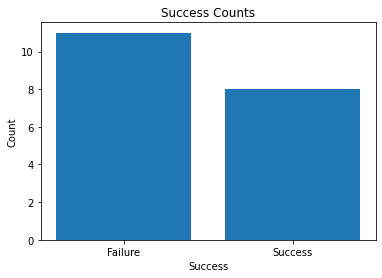

In [121]:
#Count the number of successes and failures
success_counts = white_sox_df['success'].value_counts()

#Create a bar plot
plt.bar(success_counts.index, success_counts.values)
plt.xticks(success_counts.index, ['Failure', 'Success'])
plt.xlabel('Success')
plt.ylabel('Count')
plt.title('Success Counts')

#Display the plot
plt.show()

In [122]:
white_sox_df.describe()

,Year,W,L,Finish,Attendance,Attend/G,Est. Payroll,PPF,BPF,success
count,19.000000,19.000000,19.000000,19.00000,1.800000e+01,18.000000,1.900000e+01,19.000000,19.000000,19.000000
mean,2014.000000,74.421053,77.789474,3.00000,1.950231e+06,24630.166667,1.087984e+08,101.789474,101.473684,0.421053
std,5.627314,17.359966,18.304762,1.20185,4.997730e+05,5086.213237,2.436409e+07,3.137213,3.372576,0.507257
min,2005.000000,33.000000,25.000000,1.00000,7.581090e+05,19439.000000,7.509200e+07,96.000000,96.000000,0.000000
25%,2009.500000,69.500000,73.000000,2.00000,1.650036e+06,20441.250000,9.265875e+07,99.000000,98.000000,0.000000
50%,2014.000000,78.000000,83.000000,3.00000,1.867184e+06,23051.500000,1.086718e+08,103.000000,103.000000,0.000000
75%,2018.500000,86.500000,89.000000,4.00000,2.261717e+06,27922.750000,1.186372e+08,104.000000,104.000000,1.000000
max,2023.000000,99.000000,100.000000,5.00000,2.957414e+06,36511.000000,1.639583e+08,106.000000,106.000000,1.000000


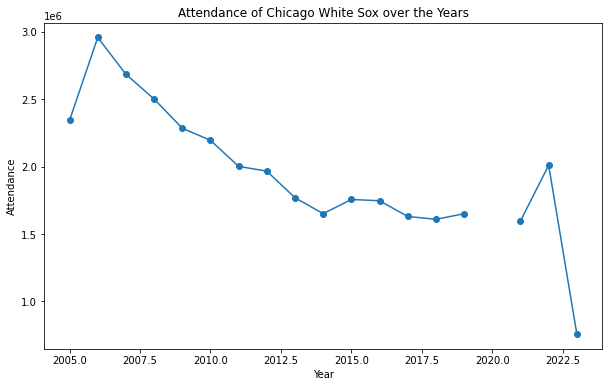

In [123]:
#Plotting
#Convert columns to numpy arrays
year = np.array(white_sox_df['Year'])
attendance = np.array(white_sox_df['Attendance'])

plt.figure(figsize= (10,6))

#Plotting Attendance over the years
plt.plot(year, attendance, marker='o')
plt.xlabel('Year')
plt.ylabel('Attendance')
plt.title('Attendance of Chicago White Sox over the Years')

#Display the plot
plt.show()

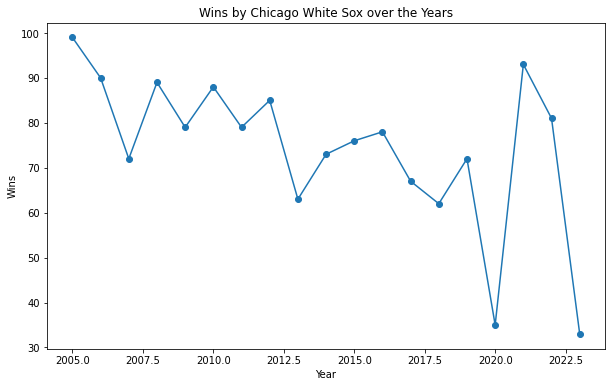

In [124]:
#Plotting Wins over the years
#Convert columns to numpy arrays
year = np.array(white_sox_df['Year'])
wins = np.array(white_sox_df['W'])

plt.figure(figsize= (10,6))

#Plotting Attendance over the years
plt.plot(year, wins, marker='o')
plt.xlabel('Year')
plt.ylabel('Wins')
plt.title('Wins by Chicago White Sox over the Years')

#Display the plot
plt.show()

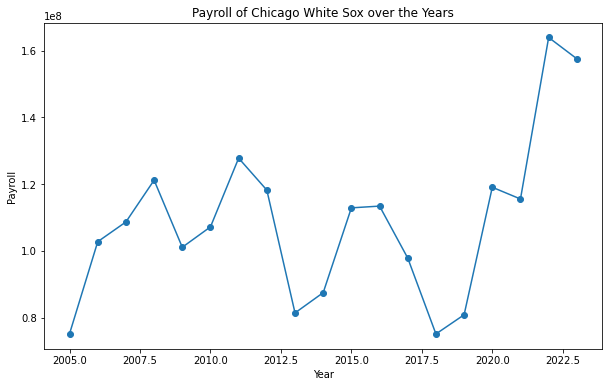

In [125]:
#Plotting Payroll over the years
#Convert columns to numpy arrays
year = np.array(white_sox_df['Year'])
payroll = np.array(white_sox_df['Est. Payroll'])

plt.figure(figsize= (10,6))

#Plotting Attendance over the years
plt.plot(year, payroll, marker='o')
plt.xlabel('Year')
plt.ylabel('Payroll')
plt.title('Payroll of Chicago White Sox over the Years')

#Display the plot
plt.show()

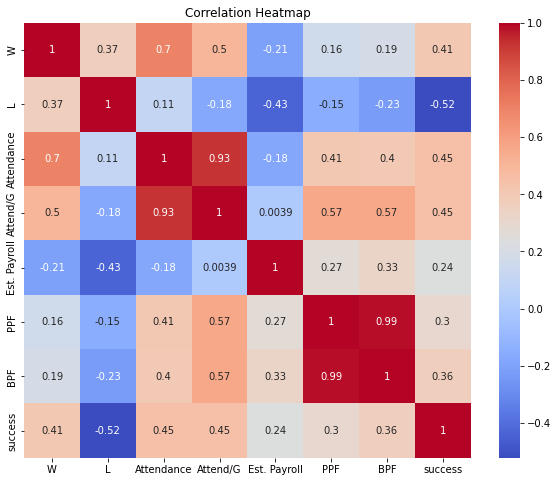

In [126]:
# Select numeric columns for correlation analysis
numeric_cols = ['W', 'L', 'Attendance', 'Attend/G', 'Est. Payroll', 'PPF', 'BPF', 'success']
numeric_df = white_sox_df[numeric_cols]

# Correlation matrix
correlation = numeric_df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

# Display the plot
plt.show()

In [127]:
#Extract the year from the "Date" column in df DataFrame
cws_df['Year'] = pd.to_datetime(cws_df['Date']).dt.year

#Merge df and white_sox_df DataFrames on the "Year" column
merged_cws_df = pd.merge(cws_df, white_sox_df[['Year', 'success']], on='Year', how='left')

#Add a new column 'Year_Successful' based on 'success' column
merged_cws_df['Year_Successful'] = merged_cws_df['success'].fillna(0).astype(int)

merged_cws_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful
0,"MLBTR Trade Rumors Podcast: Exciting Youth Movements in Cincinnati and Pittsburgh, Bad Central D...",Darragh McDonald,2023-06-21,"The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w...",2023,0,0
1,"AL Central Notes: Buxton, Crochet, Tigers",Darragh McDonald,2023-06-21,"Twins outfielder Byron Buxton has dealt with many injuries throughout his career, which has led ...",2023,0,0
2,White Sox Claim Touki Toussaint From Guardians,Darragh McDonald,2023-06-20,"The White Sox have claimed right-hander Touki Toussaint off waivers from the Guardians, per anno...",2023,0,0
3,White Sox Recall Jose Rodriguez For MLB Debut,Anthony Franco,2023-06-19,The White Sox announced a handful of transactions before tonight’s series opener with the Ranger...,2023,0,0
4,White Sox Place Mike Clevinger On Injured List,Anthony Franco,2023-06-16,"The White Sox placed starter Mike Clevinger on the 15-day injured list, retroactive to June 15, ...",2023,0,0


In [128]:
len(merged_cws_df)

1000

## Cleaning the Data

In [129]:
#Identify any noise in the data
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)


In [130]:
merged_cws_df['Content'].apply

<bound method Series.apply of 0      The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w...
1      Twins outfielder Byron Buxton has dealt with many injuries throughout his career, which has led ...
2      The White Sox have claimed right-hander Touki Toussaint off waivers from the Guardians, per anno...
3      The White Sox announced a handful of transactions before tonight’s series opener with the Ranger...
4      The White Sox placed starter Mike Clevinger on the 15-day injured list, retroactive to June 15, ...
                                                      ...                                                 
995    The White Sox have outrighted catcher Dustin Garneau to Triple-A Charlotte, Daryl Van Schouwen o...
996    White Sox GM Rick Hahn addressed the media yesterday regarding the state of his organization’s r...
997    White Sox outfielder Avisail Garcia is set to undergo right knee surgery, he told reporters incl...
998    

In [131]:
pd.options.display.max_colwidth = 100 ###
#Add new column to data frame
merged_cws_df['impurity'] = merged_cws_df['Content'].apply(impurity, min_len=10)

#Get the top 3 records
merged_cws_df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
333,"The White Sox aren’t planning to make any coaching changes, manager Tony La Russa told Daryl Van...",0.003578
875,Eloy Jimenez’s career-opening extension with the White Sox included “an understanding” that Jime...,0.002797
450,"Adam Engel will begin the season the injured list, as White Sox manager Tony La Russa told repor...",0.002782


The above shows the highest impurity levels for the White Sox's data set. Note, these are extremely low...well below 1% of all characters in each blog post are suspicious.

# Character Normalization and Tokenization

In [132]:
#Example function to normalize the text in the "Contents" column
def normalize_text(text):
    #Lowercase the text
    text = text.lower()

    #Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    #Remove special characters and digits
    text = re.sub(r"[^a-zA-Z]", " ", text)

    #Tokenize the text
    tokens = word_tokenize(text)

    #Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    #Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens


In [133]:
#Apply normalization to the "Contents" column
merged_cws_df["Contents_Normalized"] = merged_cws_df["Content"].apply(normalize_text)

#Print the head of the DataFrame with the normalized contents
merged_cws_df[["Content", "Contents_Normalized"]].head()

,Content,Contents_Normalized
0,"The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w...","[latest, episod, mlb, trade, rumor, podcast, live, spotifi, appl, podcast, wherev, get, podcast,..."
1,"Twins outfielder Byron Buxton has dealt with many injuries throughout his career, which has led ...","[twin, outfield, byron, buxton, dealt, mani, injuri, throughout, career, led, twin, use, exclus,..."
2,"The White Sox have claimed right-hander Touki Toussaint off waivers from the Guardians, per anno...","[white, sox, claim, righthand, touki, toussaint, waiver, guardian, per, announc, club, design, a..."
3,The White Sox announced a handful of transactions before tonight’s series opener with the Ranger...,"[white, sox, announc, hand, transact, tonight, seri, open, ranger, notabl, recal, infield, prosp..."
4,"The White Sox placed starter Mike Clevinger on the 15-day injured list, retroactive to June 15, ...","[white, sox, place, starter, mike, cleving, day, injur, list, retroact, june, due, bicep, inflam..."


In [134]:
merged_cws_df['length'] = merged_cws_df['Contents_Normalized'].str.len()
merged_cws_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length
0,"MLBTR Trade Rumors Podcast: Exciting Youth Movements in Cincinnati and Pittsburgh, Bad Central D...",Darragh McDonald,2023-06-21,"The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w...",2023,0,0,0.0,"[latest, episod, mlb, trade, rumor, podcast, live, spotifi, appl, podcast, wherev, get, podcast,...",124
1,"AL Central Notes: Buxton, Crochet, Tigers",Darragh McDonald,2023-06-21,"Twins outfielder Byron Buxton has dealt with many injuries throughout his career, which has led ...",2023,0,0,0.0,"[twin, outfield, byron, buxton, dealt, mani, injuri, throughout, career, led, twin, use, exclus,...",377
2,White Sox Claim Touki Toussaint From Guardians,Darragh McDonald,2023-06-20,"The White Sox have claimed right-hander Touki Toussaint off waivers from the Guardians, per anno...",2023,0,0,0.0,"[white, sox, claim, righthand, touki, toussaint, waiver, guardian, per, announc, club, design, a...",143
3,White Sox Recall Jose Rodriguez For MLB Debut,Anthony Franco,2023-06-19,The White Sox announced a handful of transactions before tonight’s series opener with the Ranger...,2023,0,0,0.0,"[white, sox, announc, hand, transact, tonight, seri, open, ranger, notabl, recal, infield, prosp...",165
4,White Sox Place Mike Clevinger On Injured List,Anthony Franco,2023-06-16,"The White Sox placed starter Mike Clevinger on the 15-day injured list, retroactive to June 15, ...",2023,0,0,0.0,"[white, sox, place, starter, mike, cleving, day, injur, list, retroact, june, due, bicep, inflam...",229


# Analyze descriptive statistics for text in dataframe.

<Axes: >

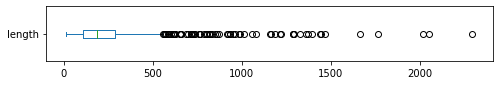

In [135]:
merged_cws_df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: >

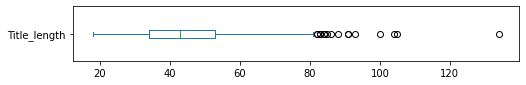

In [136]:
merged_cws_df['Title_length'] = merged_cws_df['Title'].str.len()
merged_cws_df['Title_length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: ylabel='Frequency'>

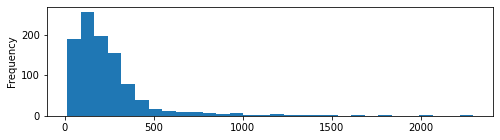

In [137]:
merged_cws_df['length'].plot(kind='hist', bins=30, figsize=(8,2))

In [138]:
# Extract the month from the date and create a new column
merged_cws_df['Month'] = merged_cws_df['Date'].dt.month

<Axes: title={'center': 'Avg. Post Length'}, xlabel='Month'>

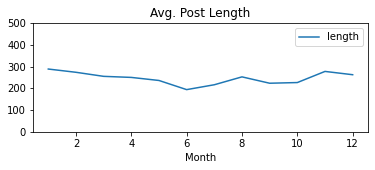

In [139]:
# Plot the average post length
merged_cws_df.groupby('Month').agg({'length': 'mean'}) \
  .plot(title="Avg. Post Length", ylim=(0,500), figsize=(6,2))

In [140]:
def count_words(df, column='Contents_Normalized', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    tqdm.pandas() #initialize tqdm for progress bar
    df[column].apply(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)


In [141]:
freq_df = count_words(merged_cws_df)
freq_df.head(5)

,freq
token,
sox,3881
season,3077
white,2872
year,2174
mm,1970


In [142]:
#How many tokens are in the df?
len(freq_df)

6278

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

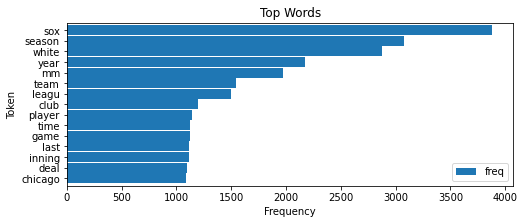

In [143]:
# top words with 10+ characters
count_words(merged_cws_df, column='Content', 
            preprocess=lambda Content: re.findall(r"\w{10,}", Content)).head(5)


ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# Los Angeles Angels Data Collection and Cleaning

In [144]:
#URL of the website to scrape
url = "https://www.mlbtraderumors.com/los-angeles-angels?show=all"
file_path = "C:/Users/andre/OneDrive/Project/mlbtraderumors_los_angeles_angels_articles1.txt"

#Scrape the website, write the scraped text to a file, and get the head of the DataFrame
laa_df = scrape_website(url, file_path)
laa_df.head()

,Title,Author,Date,Content
0,Angels Acquire Mike Moustakas,Tim Dierkes,"June 24, 2023","The Angels acquired infielder Mike Moustakas tonight, sending minor league righty Connor Van Sco..."
1,Latest On Matt Moore,Nick Deeds,"June 24, 2023",Angels lefty Matt Moore is making progress in his rehab from an oblique injury that has left his...
2,Angels Designate Chris Okey For Assignment,Nick Deeds,"June 24, 2023","The Angels have designated catcher Chris Okey for assignment, according to Sam Blum of The Athle..."
3,Angels To Promote David Fletcher,Mark Polishuk,"June 24, 2023",12:04PM: Walsh and infielder Michael Stefanic have been optioned to Triple-A to make room for Fl...
4,Angels Acquire Eduardo Escobar,Anthony Franco,"June 23, 2023",The Mets and Angels pulled off an unexpected swap Friday night. New York dealt veteran infielder...


In [145]:
#Change the Data column to a datetime object:
laa_df['Date'] = pd.to_datetime(laa_df['Date'], format="%B %d, %Y", errors= 'coerce')

In [146]:
laa_df.dtypes

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object

In [147]:
#Check for missing values
laa_df.isna().sum()

Title       0
Author      0
Date       30
Content     0
dtype: int64

In [148]:
len(laa_df)

1030

In [149]:
laa_df = laa_df.dropna()
laa_df

,Title,Author,Date,Content
0,Angels Acquire Mike Moustakas,Tim Dierkes,2023-06-24,"The Angels acquired infielder Mike Moustakas tonight, sending minor league righty Connor Van Sco..."
1,Latest On Matt Moore,Nick Deeds,2023-06-24,Angels lefty Matt Moore is making progress in his rehab from an oblique injury that has left his...
2,Angels Designate Chris Okey For Assignment,Nick Deeds,2023-06-24,"The Angels have designated catcher Chris Okey for assignment, according to Sam Blum of The Athle..."
3,Angels To Promote David Fletcher,Mark Polishuk,2023-06-24,12:04PM: Walsh and infielder Michael Stefanic have been optioned to Triple-A to make room for Fl...
4,Angels Acquire Eduardo Escobar,Anthony Franco,2023-06-23,The Mets and Angels pulled off an unexpected swap Friday night. New York dealt veteran infielder...
...,...,...,...,...
995,Angels Focused On Acquiring Players Controlled Beyond 2019,Steve Adams,2019-07-19,"At 50-48 and 11 games back in the American League West, the Angels don’t have much hope of conte..."
996,Albert Pujols Leaves Game With Hamstring Tightness,Connor Byrne,2019-07-19,Angels first baseman Albert Pujols exited the team’s game Thursday with left hamstring tightness...
997,"Outrighted: Mac Williamson, Jarrett Parker",Jeff Todd,2019-07-17,"We’ll use this post to cover the day’s minor moves, both involving a pair of former Giants outfi..."
998,"Hector Neris, Noe Ramirez Receive 3-Game Suspensions",Jeff Todd,2019-07-17,5:03pm: Angels righty Noe Ramirez has also been suspended for a trio of contests after also bein...


In [150]:
len(laa_df)

1000

## Import data on the Los Angeles Angels from baseball-reference.com.

https://www.baseball-reference.com/teams/ANA/attend.shtml


In [151]:
#URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/ANA/attend.shtml"

#Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

#Select the table of interest (index 0 in this case)
table = tables[0]

#Save the DataFrame as a CSV file
file_path = "C:/Users/andre/OneDrive/Project/MLB_data/angels_statistics.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)

Data saved to C:/Users/andre/OneDrive/Project/MLB_data/angels_statistics.csv


In [152]:
path = "C:/Users/andre/OneDrive/Project/MLB_data/"

angels_df = pd.DataFrame(pd.read_csv(path + 'angels_statistics.csv'))
angels_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Los Angeles Angels,AL West,42,36,2,NaN,1181985.0,32833.0,5th of 15,"$224,228,095",103,103,Angel Stadium of Anaheim
1,2022,Los Angeles Angels,AL West,73,89,3,NaN,2457461.0,30339.0,5th of 15,"$177,063,095",103,103,Angel Stadium of Anaheim
2,2021,Los Angeles Angels,AL West,77,85,4,NaN,1515689.0,18484.0,6th of 15,"$188,408,595",103,103,Angel Stadium of Anaheim
3,2020,Los Angeles Angels,AL West,26,34,4,NaN,NaN,NaN,8th of 15,"$181,254,762",102,101,Angel Stadium of Anaheim
4,2019,Los Angeles Angels,AL West,72,90,4,NaN,3023012.0,37321.0,2nd of 15,"$158,078,584",100,100,Angel Stadium of Anaheim


In [153]:
angels_df= angels_df[angels_df['Year'] > 2004]
angels_df

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Los Angeles Angels,AL West,42,36,2,NaN,1181985.0,32833.0,5th of 15,"$224,228,095",103,103,Angel Stadium of Anaheim
1,2022,Los Angeles Angels,AL West,73,89,3,NaN,2457461.0,30339.0,5th of 15,"$177,063,095",103,103,Angel Stadium of Anaheim
2,2021,Los Angeles Angels,AL West,77,85,4,NaN,1515689.0,18484.0,6th of 15,"$188,408,595",103,103,Angel Stadium of Anaheim
3,2020,Los Angeles Angels,AL West,26,34,4,NaN,NaN,NaN,8th of 15,"$181,254,762",102,101,Angel Stadium of Anaheim
4,2019,Los Angeles Angels,AL West,72,90,4,NaN,3023012.0,37321.0,2nd of 15,"$158,078,584",100,100,Angel Stadium of Anaheim
5,2018,Los Angeles Angels,AL West,80,82,4,NaN,3020216.0,37287.0,2nd of 15,"$166,849,666",98,98,Angel Stadium of Anaheim
6,2017,Los Angeles Angels,AL West,80,82,2,NaN,3019585.0,37279.0,3rd of 15,"$181,125,500",97,97,Angel Stadium of Anaheim
7,2016,Los Angeles Angels,AL West,74,88,4,NaN,3016142.0,37236.0,3rd of 15,"$139,712,000",95,95,Angel Stadium of Anaheim
8,2015,Los Angeles Angels of Anaheim,AL West,85,77,3,NaN,3012765.0,37195.0,2nd of 15,"$131,522,500",94,94,Angel Stadium of Anaheim
9,2014,Los Angeles Angels of Anaheim,AL West,98,64,1,Lost ALDS (3-0),3095935.0,38221.0,2nd of 15,"$128,667,000",94,95,Angel Stadium of Anaheim


In [154]:
#Remove the dollar and comma signs from the 'Estimated Payroll' column:
angels_df['Est. Payroll'] = angels_df['Est. Payroll'].replace({'\$':''}, regex = True)
angels_df['Est. Payroll'] = angels_df['Est. Payroll'].replace({'\,':''}, regex = True)
angels_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Los Angeles Angels,AL West,42,36,2,NaN,1181985.0,32833.0,5th of 15,224228095,103,103,Angel Stadium of Anaheim
1,2022,Los Angeles Angels,AL West,73,89,3,NaN,2457461.0,30339.0,5th of 15,177063095,103,103,Angel Stadium of Anaheim
2,2021,Los Angeles Angels,AL West,77,85,4,NaN,1515689.0,18484.0,6th of 15,188408595,103,103,Angel Stadium of Anaheim
3,2020,Los Angeles Angels,AL West,26,34,4,NaN,NaN,NaN,8th of 15,181254762,102,101,Angel Stadium of Anaheim
4,2019,Los Angeles Angels,AL West,72,90,4,NaN,3023012.0,37321.0,2nd of 15,158078584,100,100,Angel Stadium of Anaheim


In [155]:
angels_df['Est. Payroll'] = angels_df['Est. Payroll'].astype(float)
angels_df.dtypes

Year              int64
Tm               object
Lg               object
W                 int64
L                 int64
Finish            int64
Playoffs         object
Attendance      float64
Attend/G        float64
Rank             object
Est. Payroll    float64
PPF               int64
BPF               int64
Stadium          object
dtype: object

## Create Binary feature that defines a successful year as wins greater than or equal to 50% of total games played

In [156]:
#Add a column to define a binary output that has a 1 if the team has a winning record for the year, and 0 if they do not
angels_df['success'] = (angels_df['W'] / (angels_df['W'] + angels_df['L']) >= 0.5).astype(int)
angels_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium,success
0,2023,Los Angeles Angels,AL West,42,36,2,NaN,1181985.0,32833.0,5th of 15,224228095.0,103,103,Angel Stadium of Anaheim,1
1,2022,Los Angeles Angels,AL West,73,89,3,NaN,2457461.0,30339.0,5th of 15,177063095.0,103,103,Angel Stadium of Anaheim,0
2,2021,Los Angeles Angels,AL West,77,85,4,NaN,1515689.0,18484.0,6th of 15,188408595.0,103,103,Angel Stadium of Anaheim,0
3,2020,Los Angeles Angels,AL West,26,34,4,NaN,NaN,NaN,8th of 15,181254762.0,102,101,Angel Stadium of Anaheim,0
4,2019,Los Angeles Angels,AL West,72,90,4,NaN,3023012.0,37321.0,2nd of 15,158078584.0,100,100,Angel Stadium of Anaheim,0


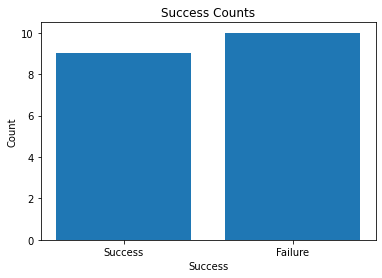

In [157]:
#Count the number of successes and failures
success_counts = angels_df['success'].value_counts()

#Create a bar plot
plt.bar(success_counts.index, success_counts.values)
plt.xticks(success_counts.index, ['Failure', 'Success'])
plt.xlabel('Success')
plt.ylabel('Count')
plt.title('Success Counts')

#Display the plot
plt.show()

In [158]:
angels_df.describe()

,Year,W,L,Finish,Attendance,Attend/G,Est. Payroll,PPF,BPF,success
count,19.000000,19.000000,19.000000,19.000000,1.800000e+01,18.000000,1.900000e+01,19.000000,19.000000,19.000000
mean,2014.000000,79.736842,72.473684,2.526316,2.921969e+06,37074.388889,1.433158e+08,97.894737,98.157895,0.526316
std,5.627314,18.525784,15.837257,1.172292,6.151490e+05,5527.931452,3.515893e+07,3.649882,3.531810,0.512989
min,2005.000000,26.000000,34.000000,1.000000,1.181985e+06,18484.000000,9.486782e+07,92.000000,92.000000,0.000000
25%,2009.500000,75.500000,66.000000,1.500000,3.016983e+06,37246.500000,1.173508e+08,94.500000,95.000000,0.000000
50%,2014.000000,80.000000,76.000000,3.000000,3.042391e+06,37560.500000,1.385432e+08,98.000000,98.000000,1.000000
75%,2018.500000,91.500000,83.000000,3.500000,3.248207e+06,40101.750000,1.719564e+08,101.000000,101.000000,1.000000
max,2023.000000,100.000000,90.000000,4.000000,3.406790e+06,42059.000000,2.242281e+08,103.000000,103.000000,1.000000


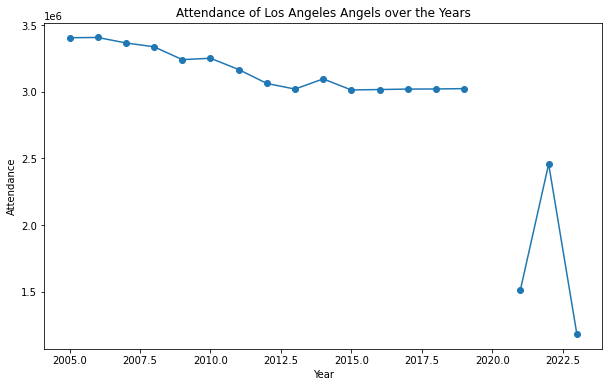

In [159]:
#Plotting the data
#Convert columns to numpy arrays
year = np.array(angels_df['Year'])
attendance = np.array(angels_df['Attendance'])

plt.figure(figsize=(10, 6))

#Plotting Attendance over the years
plt.plot(year, attendance, marker='o')
plt.xlabel('Year')
plt.ylabel('Attendance')
plt.title('Attendance of Los Angeles Angels over the Years')

#Display the plot
plt.show()

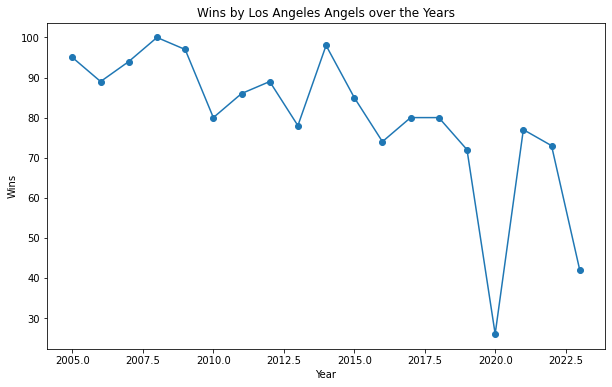

In [160]:
#Plotting Wins over the years
year = np.array(angels_df['Year'])
wins = np.array(angels_df['W'])

plt.figure(figsize= (10,6))

#Plotting Attendance over the years
plt.plot(year, wins, marker='o')
plt.xlabel('Year')
plt.ylabel('Wins')
plt.title('Wins by Los Angeles Angels over the Years')

#Display the plot
plt.show()

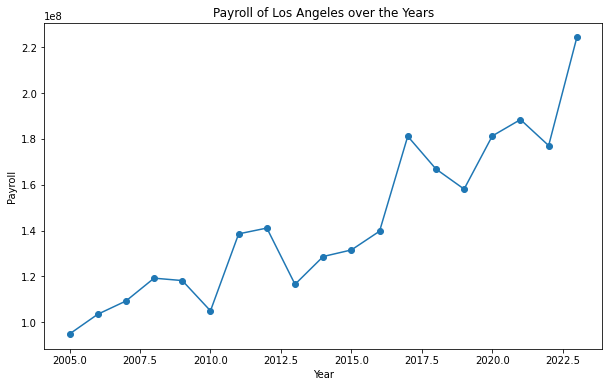

In [161]:
#Plotting Payroll over the years
#Convert columns to numpy arrays
year = np.array(angels_df['Year'])
payroll = np.array(angels_df['Est. Payroll'])

plt.figure(figsize= (10,6))

#Plotting Attendance over the years
plt.plot(year, payroll, marker='o')
plt.xlabel('Year')
plt.ylabel('Payroll')
plt.title('Payroll of Los Angeles over the Years')

#Display the plot
plt.show()

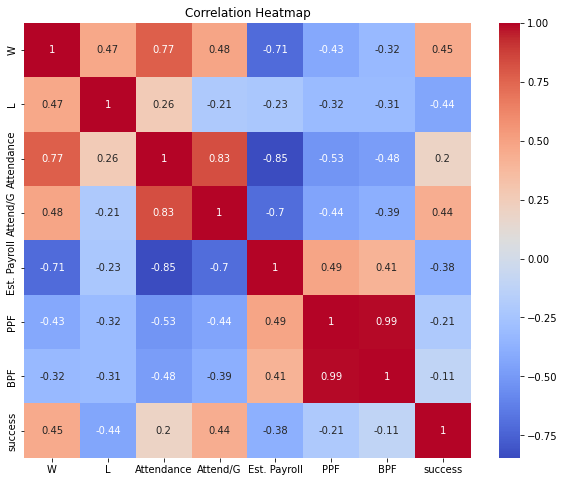

In [162]:
#Select numeric columns for correlation analysis
numeric_cols = ['W', 'L', 'Attendance', 'Attend/G', 'Est. Payroll', 'PPF', 'BPF', 'success']
numeric_df = angels_df[numeric_cols]

#Correlation matrix
correlation = numeric_df.corr()

#Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

#Display the plot
plt.show()

### Add column to analyze whether blog post occurred in a successful year or not.

In [163]:
#Extract the year from the "Date" column in df DataFrame
laa_df['Year'] = pd.to_datetime(laa_df['Date']).dt.year

#Merge df and athletics_df DataFrames on the "Year" column
merged_laa_df = pd.merge(laa_df, angels_df[['Year', 'success']], on='Year', how='left')

#Add a new column 'Year_Successful' based on 'success' column
merged_laa_df['Year_Successful'] = merged_laa_df['success'].fillna(0).astype(int)

merged_laa_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful
0,Angels Acquire Mike Moustakas,Tim Dierkes,2023-06-24,"The Angels acquired infielder Mike Moustakas tonight, sending minor league righty Connor Van Sco...",2023,1,1
1,Latest On Matt Moore,Nick Deeds,2023-06-24,Angels lefty Matt Moore is making progress in his rehab from an oblique injury that has left his...,2023,1,1
2,Angels Designate Chris Okey For Assignment,Nick Deeds,2023-06-24,"The Angels have designated catcher Chris Okey for assignment, according to Sam Blum of The Athle...",2023,1,1
3,Angels To Promote David Fletcher,Mark Polishuk,2023-06-24,12:04PM: Walsh and infielder Michael Stefanic have been optioned to Triple-A to make room for Fl...,2023,1,1
4,Angels Acquire Eduardo Escobar,Anthony Franco,2023-06-23,The Mets and Angels pulled off an unexpected swap Friday night. New York dealt veteran infielder...,2023,1,1


In [164]:
len(merged_laa_df)

1000

## Cleaning the Angels' Data

In [165]:
#Identify any noise in the data
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)


In [166]:
merged_laa_df['Content'].apply

<bound method Series.apply of 0      The Angels acquired infielder Mike Moustakas tonight, sending minor league righty Connor Van Sco...
1      Angels lefty Matt Moore is making progress in his rehab from an oblique injury that has left his...
2      The Angels have designated catcher Chris Okey for assignment, according to Sam Blum of The Athle...
3      12:04PM: Walsh and infielder Michael Stefanic have been optioned to Triple-A to make room for Fl...
4      The Mets and Angels pulled off an unexpected swap Friday night. New York dealt veteran infielder...
                                                      ...                                                 
995    At 50-48 and 11 games back in the American League West, the Angels don’t have much hope of conte...
996    Angels first baseman Albert Pujols exited the team’s game Thursday with left hamstring tightness...
997    We’ll use this post to cover the day’s minor moves, both involving a pair of former Giants outfi...
998    

In [167]:
pd.options.display.max_colwidth = 100 ###
#Add new column to data frame
merged_laa_df['impurity'] = merged_laa_df['Content'].apply(impurity, min_len=10)

#Get the top 3 records
merged_laa_df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
62,"An early look at the trade deadline possibilities, particularly focusing on Shohei Ohtani and wh...",0.010753
737,"According to the Centers for Disease Control and Prevention, people over the age of 65 and cance...",0.004571
237,"A pair of top ten picks, Gavin Cross and Elijah Green, agreed to terms with their teams today. A...",0.003884


The above shows the highest impurity levels for the Angels' data set. Note, these are extremely low...well below 1% of all characters in each blog post are suspicious.

## Character Normalization and Tokenization

In [168]:
#Example function to normalize the text in the "Contents" column
def normalize_text(text):
    #Lowercase the text
    text = text.lower()

    #Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    #Remove special characters and digits
    text = re.sub(r"[^a-zA-Z]", " ", text)

    #Tokenize the text
    tokens = word_tokenize(text)

    #Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    #Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

#Apply normalization to the "Contents" column
merged_laa_df["Contents_Normalized"] = merged_laa_df["Content"].apply(normalize_text)

#Print the head of the DataFrame with the normalized contents
merged_laa_df[["Content", "Contents_Normalized"]].head()

,Content,Contents_Normalized
0,"The Angels acquired infielder Mike Moustakas tonight, sending minor league righty Connor Van Sco...","[angel, acquir, infield, mike, moustaka, tonight, send, minor, leagu, righti, connor, van, scoyo..."
1,Angels lefty Matt Moore is making progress in his rehab from an oblique injury that has left his...,"[angel, lefti, matt, moor, make, progress, rehab, obliqu, injuri, left, sidelin, nearli, month, ..."
2,"The Angels have designated catcher Chris Okey for assignment, according to Sam Blum of The Athle...","[angel, design, catcher, chri, okey, assign, accord, sam, blum, athlet, move, complet, seri, ros..."
3,12:04PM: Walsh and infielder Michael Stefanic have been optioned to Triple-A to make room for Fl...,"[pm, walsh, infield, michael, stefan, option, triplea, make, room, fletcher, escobar, sam, blum,..."
4,The Mets and Angels pulled off an unexpected swap Friday night. New York dealt veteran infielder...,"[met, angel, pull, unexpect, swap, friday, night, new, york, dealt, veteran, infield, eduardo, e..."


In [169]:
merged_laa_df['length'] = merged_laa_df['Contents_Normalized'].str.len()
merged_laa_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length
0,Angels Acquire Mike Moustakas,Tim Dierkes,2023-06-24,"The Angels acquired infielder Mike Moustakas tonight, sending minor league righty Connor Van Sco...",2023,1,1,0.0,"[angel, acquir, infield, mike, moustaka, tonight, send, minor, leagu, righti, connor, van, scoyo...",438
1,Latest On Matt Moore,Nick Deeds,2023-06-24,Angels lefty Matt Moore is making progress in his rehab from an oblique injury that has left his...,2023,1,1,0.0,"[angel, lefti, matt, moor, make, progress, rehab, obliqu, injuri, left, sidelin, nearli, month, ...",69
2,Angels Designate Chris Okey For Assignment,Nick Deeds,2023-06-24,"The Angels have designated catcher Chris Okey for assignment, according to Sam Blum of The Athle...",2023,1,1,0.0,"[angel, design, catcher, chri, okey, assign, accord, sam, blum, athlet, move, complet, seri, ros...",171
3,Angels To Promote David Fletcher,Mark Polishuk,2023-06-24,12:04PM: Walsh and infielder Michael Stefanic have been optioned to Triple-A to make room for Fl...,2023,1,1,0.0,"[pm, walsh, infield, michael, stefan, option, triplea, make, room, fletcher, escobar, sam, blum,...",265
4,Angels Acquire Eduardo Escobar,Anthony Franco,2023-06-23,The Mets and Angels pulled off an unexpected swap Friday night. New York dealt veteran infielder...,2023,1,1,0.0,"[met, angel, pull, unexpect, swap, friday, night, new, york, dealt, veteran, infield, eduardo, e...",720


## Analyze descriptive statistics for text in dataframe.

<Axes: >

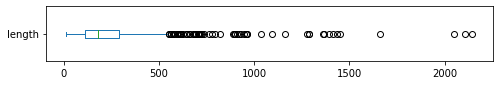

In [170]:
merged_laa_df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: >

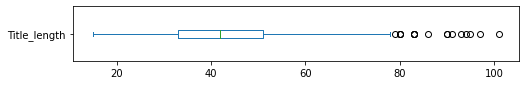

In [171]:
merged_laa_df['Title_length'] = merged_laa_df['Title'].str.len()
merged_laa_df['Title_length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: ylabel='Frequency'>

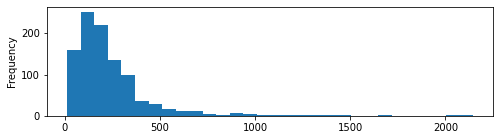

In [172]:
merged_laa_df['length'].plot(kind='hist', bins=30, figsize=(8,2))

<Axes: title={'center': 'Avg. Post Length'}, xlabel='Month'>

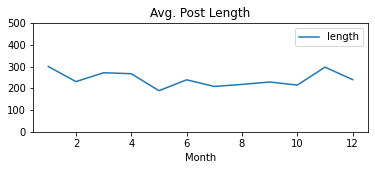

In [173]:
#Extract the month from the date and create a new column
merged_laa_df['Month'] = merged_laa_df['Date'].dt.month

#Plot the average post length
merged_laa_df.groupby('Month').agg({'length': 'mean'}) \
  .plot(title="Avg. Post Length", ylim=(0,500), figsize=(6,2))

In [174]:
def count_words(df, column='Contents_Normalized', preprocess=None, min_freq=2):

    #Process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    #Create counter and run through all data
    counter = Counter()
    tqdm.pandas() #initialize tqdm for progress bar
    df[column].apply(update)

    #Transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [175]:
freq_df = count_words(merged_laa_df)
freq_df.head(5)

,freq
token,
angel,3991
season,3123
year,2390
leagu,1725
team,1503


In [176]:
#How many tokens are in the df?
len(freq_df)

6268

In [177]:
#Top words with 10+ characters
count_words(merged_laa_df, column='Content', 
            preprocess=lambda Content: re.findall(r"\w{10,}", Content)).head(5)


,freq
token,
appearances,604
organization,325
assignment,317
outfielder,289
designated,262


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

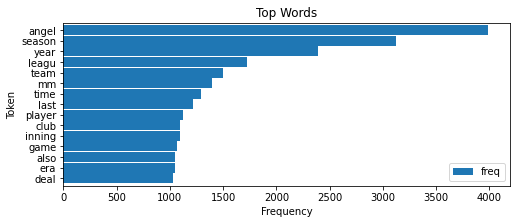

In [178]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# Los Angeles Dodgers Data Collection and Cleaning

In [179]:
#URL of the website to scrape
url = "https://www.mlbtraderumors.com/los-angeles-dodgers?show=all"
file_path = "C:/Users/andre/OneDrive/Project/mlbtraderumors_los_angeles_dodgers_articles1.txt"

#Scrape the website, write the scraped text to a file, and get the head of the DataFrame
lad_df = scrape_website(url, file_path)
lad_df.head()

,Title,Author,Date,Content
0,"Dodgers Notes: Muncy, Rotation, Thor",Nick Deeds,"June 24, 2023",Dodgers manager Dave Roberts told reporters today (including Mike DiGiovanna of the Los Angeles ...
1,Dodgers To Stick With Emmet Sheehan In Rotation Next Week,Mark Polishuk,"June 24, 2023","Emmet Sheehan’s MLB career is off to a tremendous start, as the Dodgers prospect has a 1.50 ERA ..."
2,Red Sox Acquire Tayler Scott From Dodgers,Darragh McDonald,"June 22, 2023",The Red Sox announced that they have acquired right-hander Tayler Scott from the Dodgers in exch...
3,"MLBTR Trade Rumors Podcast: Exciting Youth Movements in Cincinnati and Pittsburgh, Bad Central D...",Darragh McDonald,"June 21, 2023","The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w..."
4,Dodgers Sign David Dahl To Minor League Contract,Anthony Franco,"June 20, 2023","Veteran outfielder David Dahl has signed a minor league deal with the Dodgers, according to Trip..."


In [180]:
#Change the Data column to a datetime object:
lad_df['Date'] = pd.to_datetime(lad_df['Date'], format="%B %d, %Y", errors= 'coerce')

In [181]:
lad_df.dtypes

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object

In [182]:
#Check for missing values
lad_df.isna().sum()

Title       0
Author      0
Date       30
Content     0
dtype: int64

In [183]:
len(lad_df)

1030

In [184]:
lad_df = lad_df.dropna()
lad_df

,Title,Author,Date,Content
0,"Dodgers Notes: Muncy, Rotation, Thor",Nick Deeds,2023-06-24,Dodgers manager Dave Roberts told reporters today (including Mike DiGiovanna of the Los Angeles ...
1,Dodgers To Stick With Emmet Sheehan In Rotation Next Week,Mark Polishuk,2023-06-24,"Emmet Sheehan’s MLB career is off to a tremendous start, as the Dodgers prospect has a 1.50 ERA ..."
2,Red Sox Acquire Tayler Scott From Dodgers,Darragh McDonald,2023-06-22,The Red Sox announced that they have acquired right-hander Tayler Scott from the Dodgers in exch...
3,"MLBTR Trade Rumors Podcast: Exciting Youth Movements in Cincinnati and Pittsburgh, Bad Central D...",Darragh McDonald,2023-06-21,"The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w..."
4,Dodgers Sign David Dahl To Minor League Contract,Anthony Franco,2023-06-20,"Veteran outfielder David Dahl has signed a minor league deal with the Dodgers, according to Trip..."
...,...,...,...,...
995,Morosi: 50/50 Chance Of Nolan Arenado Trade,Jeff Todd,2020-01-02,"With the market showing a big appetite for star third basemen, the Rockies now appear to be incr..."
996,Remaining Needs: NL West,Jeff Todd,2019-12-30,"With the offseason almost two months old, MLBTR is going through all 30 teams’ remaining needs b..."
997,Dodgers Release JT Chargois,George Miller,2019-12-29,"Sunday: Chargois, as it turns out, has been acquired by the Rakuten Golden Eagles of NPB’s Pacif..."
998,Examining The Dodgers' Slow Offseason,Anthony Franco,2019-12-25,"The Dodgers have had a quiet start to the offseason, observes Andy McCullough of the Athletic. G..."


In [185]:
len(lad_df)

1000

## Import data on the Los Angeles Dodgers from baseball-reference.com.

https://www.baseball-reference.com/teams/LAD/attend.shtml


In [186]:
#URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/LAD/attend.shtml"

#Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

#Select the table of interest (index 0 in this case)
table = tables[0]

#Save the DataFrame as a CSV file
file_path = "C:/Users/andre/OneDrive/Project/MLB_data/dodgers_statistics.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)

Data saved to C:/Users/andre/OneDrive/Project/MLB_data/dodgers_statistics.csv


In [187]:
path = "C:/Users/andre/OneDrive/Project/MLB_data/"

dodgers_df = pd.DataFrame(pd.read_csv(path + 'dodgers_statistics.csv'))
dodgers_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Los Angeles Dodgers,NL West,43,33,3,NaN,1827910.0,48103.0,1st of 15,"$198,971,667",101,103,Dodger Stadium
1,2022,Los Angeles Dodgers,NL West,111,51,1,Lost NLDS (3-1),3861408.0,47672.0,1st of 15,"$261,180,131",101,103,Dodger Stadium
2,2021,Los Angeles Dodgers,NL West,106,56,2,Lost NLCS (4-2),2804693.0,34626.0,1st of 15,"$248,108,334",100,103,Dodger Stadium
3,2020,Los Angeles Dodgers,NL West,43,17,1,Won WS (4-2),NaN,NaN,6th of 15,"$216,508,333",97,99,Dodger Stadium
4,2019,Los Angeles Dodgers,NL West,106,56,1,Lost NLDS (3-2),3974309.0,49066.0,1st of 15,"$193,553,333",94,97,Dodger Stadium


In [188]:
dodgers_df= dodgers_df[dodgers_df['Year'] > 2004]
dodgers_df

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Los Angeles Dodgers,NL West,43,33,3,NaN,1827910.0,48103.0,1st of 15,"$198,971,667",101,103,Dodger Stadium
1,2022,Los Angeles Dodgers,NL West,111,51,1,Lost NLDS (3-1),3861408.0,47672.0,1st of 15,"$261,180,131",101,103,Dodger Stadium
2,2021,Los Angeles Dodgers,NL West,106,56,2,Lost NLCS (4-2),2804693.0,34626.0,1st of 15,"$248,108,334",100,103,Dodger Stadium
3,2020,Los Angeles Dodgers,NL West,43,17,1,Won WS (4-2),NaN,NaN,6th of 15,"$216,508,333",97,99,Dodger Stadium
4,2019,Los Angeles Dodgers,NL West,106,56,1,Lost NLDS (3-2),3974309.0,49066.0,1st of 15,"$193,553,333",94,97,Dodger Stadium
5,2018,Los Angeles Dodgers,NL West,92,71,1,Lost WS (4-1),3857500.0,47043.0,1st of 15,"$164,703,429",96,98,Dodger Stadium
6,2017,Los Angeles Dodgers,NL West,104,58,1,Lost WS (4-3),3765856.0,46492.0,1st of 15,"$201,466,263",95,96,Dodger Stadium
7,2016,Los Angeles Dodgers,NL West,91,71,1,Lost NLCS (4-2),3703312.0,45720.0,1st of 15,"$231,342,096",96,97,Dodger Stadium
8,2015,Los Angeles Dodgers,NL West,92,70,1,Lost NLDS (3-2),3764815.0,46479.0,1st of 15,"$265,140,429",94,95,Dodger Stadium
9,2014,Los Angeles Dodgers,NL West,94,68,1,Lost NLDS (3-1),3782337.0,46696.0,1st of 15,"$233,386,026",95,96,Dodger Stadium


In [189]:
#Remove the dollar and comma signs from the 'Estimated Payroll' column:
dodgers_df['Est. Payroll'] = dodgers_df['Est. Payroll'].replace({'\$':''}, regex = True)
dodgers_df['Est. Payroll'] = dodgers_df['Est. Payroll'].replace({'\,':''}, regex = True)
dodgers_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Los Angeles Dodgers,NL West,43,33,3,NaN,1827910.0,48103.0,1st of 15,198971667,101,103,Dodger Stadium
1,2022,Los Angeles Dodgers,NL West,111,51,1,Lost NLDS (3-1),3861408.0,47672.0,1st of 15,261180131,101,103,Dodger Stadium
2,2021,Los Angeles Dodgers,NL West,106,56,2,Lost NLCS (4-2),2804693.0,34626.0,1st of 15,248108334,100,103,Dodger Stadium
3,2020,Los Angeles Dodgers,NL West,43,17,1,Won WS (4-2),NaN,NaN,6th of 15,216508333,97,99,Dodger Stadium
4,2019,Los Angeles Dodgers,NL West,106,56,1,Lost NLDS (3-2),3974309.0,49066.0,1st of 15,193553333,94,97,Dodger Stadium


In [190]:
dodgers_df['Est. Payroll'] = dodgers_df['Est. Payroll'].astype(float)
dodgers_df.dtypes

Year              int64
Tm               object
Lg               object
W                 int64
L                 int64
Finish            int64
Playoffs         object
Attendance      float64
Attend/G        float64
Rank             object
Est. Payroll    float64
PPF               int64
BPF               int64
Stadium          object
dtype: object

## Create Binary feature that defines a successful year as wins greater than or equal to 50% of total games played

In [191]:
#Add a column to define a binary output that has a 1 if the team has a winning record for the year, and 0 if they do not
dodgers_df['success'] = (dodgers_df['W'] / (dodgers_df['W'] + dodgers_df['L']) >= 0.5).astype(int)
dodgers_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium,success
0,2023,Los Angeles Dodgers,NL West,43,33,3,NaN,1827910.0,48103.0,1st of 15,198971667.0,101,103,Dodger Stadium,1
1,2022,Los Angeles Dodgers,NL West,111,51,1,Lost NLDS (3-1),3861408.0,47672.0,1st of 15,261180131.0,101,103,Dodger Stadium,1
2,2021,Los Angeles Dodgers,NL West,106,56,2,Lost NLCS (4-2),2804693.0,34626.0,1st of 15,248108334.0,100,103,Dodger Stadium,1
3,2020,Los Angeles Dodgers,NL West,43,17,1,Won WS (4-2),NaN,NaN,6th of 15,216508333.0,97,99,Dodger Stadium,1
4,2019,Los Angeles Dodgers,NL West,106,56,1,Lost NLDS (3-2),3974309.0,49066.0,1st of 15,193553333.0,94,97,Dodger Stadium,1


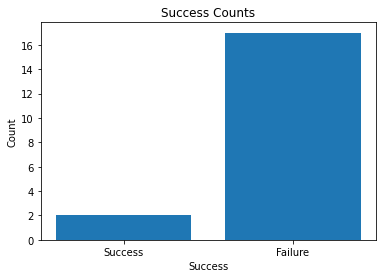

In [192]:
#Count the number of successes and failures
success_counts = dodgers_df['success'].value_counts()

#Create a bar plot
plt.bar(success_counts.index, success_counts.values)
plt.xticks(success_counts.index, ['Failure', 'Success'])
plt.xlabel('Success')
plt.ylabel('Count')
plt.title('Success Counts')

#Display the plot
plt.show()

In [193]:
dodgers_df.describe()

,Year,W,L,Finish,Attendance,Attend/G,Est. Payroll,PPF,BPF,success
count,19.000000,19.000000,19.000000,19.000000,1.800000e+01,18.000000,1.900000e+01,19.000000,19.000000,19.000000
mean,2014.000000,86.421053,65.684211,1.842105,3.534378e+06,45020.722222,1.765971e+08,96.894737,98.105263,0.894737
std,5.627314,18.291819,17.666832,1.167293,5.282122e+05,3912.082668,6.489515e+07,2.330826,2.766762,0.315302
min,2005.000000,43.000000,17.000000,1.000000,1.827910e+06,34626.000000,8.303900e+07,94.000000,95.000000,0.000000
25%,2009.500000,82.000000,57.000000,1.000000,3.572652e+06,44796.750000,1.061200e+08,95.000000,96.000000,1.000000
50%,2014.000000,91.000000,70.000000,1.000000,3.751036e+06,46421.000000,1.935533e+08,96.000000,97.000000,1.000000
75%,2018.500000,94.500000,77.000000,2.500000,3.778217e+06,46956.250000,2.323641e+08,98.500000,100.000000,1.000000
max,2023.000000,111.000000,91.000000,4.000000,3.974309e+06,49066.000000,2.651404e+08,101.000000,103.000000,1.000000


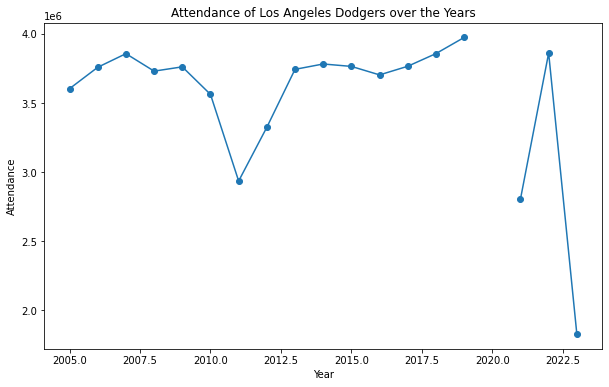

In [194]:
#Plotting the data
#Convert columns to numpy arrays
year = np.array(dodgers_df['Year'])
attendance = np.array(dodgers_df['Attendance'])

plt.figure(figsize=(10, 6))

#Plotting Attendance over the years
plt.plot(year, attendance, marker='o')
plt.xlabel('Year')
plt.ylabel('Attendance')
plt.title('Attendance of Los Angeles Dodgers over the Years')

#Display the plot
plt.show()

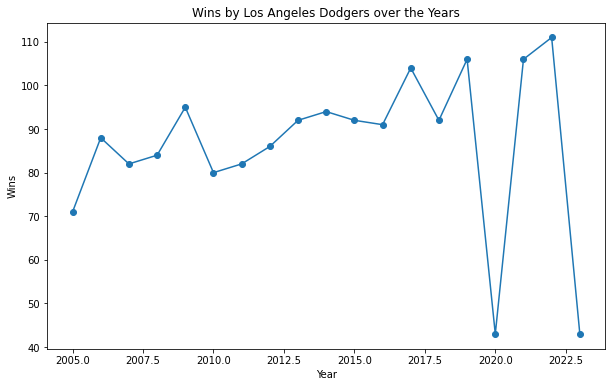

In [195]:
#Plotting Wins over the years
year = np.array(dodgers_df['Year'])
wins = np.array(dodgers_df['W'])

plt.figure(figsize= (10,6))

#Plotting Attendance over the years
plt.plot(year, wins, marker='o')
plt.xlabel('Year')
plt.ylabel('Wins')
plt.title('Wins by Los Angeles Dodgers over the Years')

#Display the plot
plt.show()

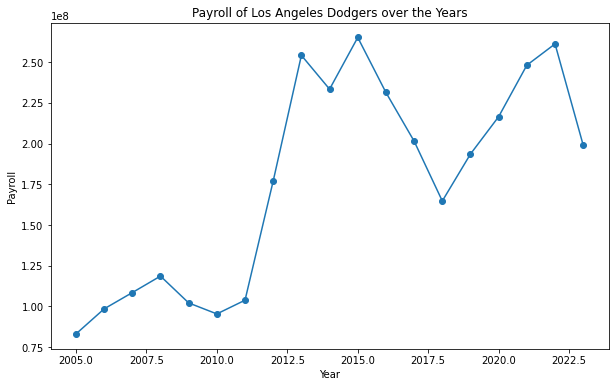

In [196]:
#Plotting Payroll over the years
#Convert columns to numpy arrays
year = np.array(dodgers_df['Year'])
payroll = np.array(dodgers_df['Est. Payroll'])

plt.figure(figsize= (10,6))

#Plotting Attendance over the years
plt.plot(year, payroll, marker='o')
plt.xlabel('Year')
plt.ylabel('Payroll')
plt.title('Payroll of Los Angeles Dodgers over the Years')

#Display the plot
plt.show()

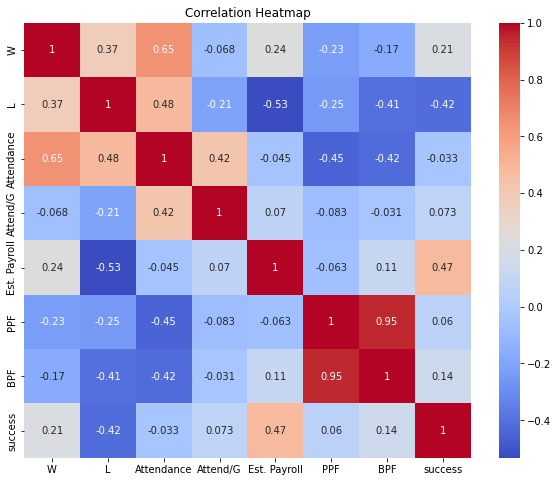

In [197]:
#Select numeric columns for correlation analysis
numeric_cols = ['W', 'L', 'Attendance', 'Attend/G', 'Est. Payroll', 'PPF', 'BPF', 'success']
numeric_df = dodgers_df[numeric_cols]

#Correlation matrix
correlation = numeric_df.corr()

#Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

#Display the plot
plt.show()

### Add column to analyze whether blog post occurred in a successful year or not.

In [198]:
#Extract the year from the "Date" column in df DataFrame
lad_df['Year'] = pd.to_datetime(lad_df['Date']).dt.year

#Merge df and athletics_df DataFrames on the "Year" column
merged_lad_df = pd.merge(lad_df, dodgers_df[['Year', 'success']], on='Year', how='left')

#Add a new column 'Year_Successful' based on 'success' column
merged_lad_df['Year_Successful'] = merged_lad_df['success'].fillna(0).astype(int)

merged_lad_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful
0,"Dodgers Notes: Muncy, Rotation, Thor",Nick Deeds,2023-06-24,Dodgers manager Dave Roberts told reporters today (including Mike DiGiovanna of the Los Angeles ...,2023,1,1
1,Dodgers To Stick With Emmet Sheehan In Rotation Next Week,Mark Polishuk,2023-06-24,"Emmet Sheehan’s MLB career is off to a tremendous start, as the Dodgers prospect has a 1.50 ERA ...",2023,1,1
2,Red Sox Acquire Tayler Scott From Dodgers,Darragh McDonald,2023-06-22,The Red Sox announced that they have acquired right-hander Tayler Scott from the Dodgers in exch...,2023,1,1
3,"MLBTR Trade Rumors Podcast: Exciting Youth Movements in Cincinnati and Pittsburgh, Bad Central D...",Darragh McDonald,2023-06-21,"The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w...",2023,1,1
4,Dodgers Sign David Dahl To Minor League Contract,Anthony Franco,2023-06-20,"Veteran outfielder David Dahl has signed a minor league deal with the Dodgers, according to Trip...",2023,1,1


In [199]:
len(merged_lad_df)

1000

## Cleaning the Dodgers' Data

In [200]:
#Identify any noise in the data
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

In [201]:
merged_lad_df['Content'].apply

<bound method Series.apply of 0      Dodgers manager Dave Roberts told reporters today (including Mike DiGiovanna of the Los Angeles ...
1      Emmet Sheehan’s MLB career is off to a tremendous start, as the Dodgers prospect has a 1.50 ERA ...
2      The Red Sox announced that they have acquired right-hander Tayler Scott from the Dodgers in exch...
3      The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w...
4      Veteran outfielder David Dahl has signed a minor league deal with the Dodgers, according to Trip...
                                                      ...                                                 
995    With the market showing a big appetite for star third basemen, the Rockies now appear to be incr...
996    With the offseason almost two months old, MLBTR is going through all 30 teams’ remaining needs b...
997    Sunday: Chargois, as it turns out, has been acquired by the Rakuten Golden Eagles of NPB’s Pacif...
998    

In [202]:
pd.options.display.max_colwidth = 100 ###
#Add new column to data frame
merged_lad_df['impurity'] = merged_lad_df['Content'].apply(impurity, min_len=10)

#Get the top 3 records
merged_lad_df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
91,"The Dodgers took a step back this winter, so how aggressive will they be at the deadline this ye...",0.010753
885,"According to the Centers for Disease Control and Prevention, people over the age of 65 and cance...",0.004571
963,"In case you missed it — which, c’mon, you call yourself a MLBTR reader?! — the Red Sox have agre...",0.003989



The steps above displays the highest impurity levels for the Dodgers' data set. The impurity levels above are extremely low, being below 1% of all characters in each blog post appear suspicious.

## Character Normalization and Tokenization

In [203]:
#Example function to normalize the text in the "Contents" column
def normalize_text(text):
    #Lowercase the text
    text = text.lower()

    #Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    #Remove special characters and digits
    text = re.sub(r"[^a-zA-Z]", " ", text)

    #Tokenize the text
    tokens = word_tokenize(text)

    #Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    #Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

#Apply normalization to the "Contents" column
merged_lad_df["Contents_Normalized"] = merged_lad_df["Content"].apply(normalize_text)

#Print the head of the DataFrame with the normalized contents
merged_lad_df[["Content", "Contents_Normalized"]].head()

,Content,Contents_Normalized
0,Dodgers manager Dave Roberts told reporters today (including Mike DiGiovanna of the Los Angeles ...,"[dodger, manag, dave, robert, told, report, today, includ, mike, digiovanna, lo, angel, time, ex..."
1,"Emmet Sheehan’s MLB career is off to a tremendous start, as the Dodgers prospect has a 1.50 ERA ...","[emmet, sheehan, mlb, career, tremend, start, dodger, prospect, era, first, inning, show, sheeha..."
2,The Red Sox announced that they have acquired right-hander Tayler Scott from the Dodgers in exch...,"[red, sox, announc, acquir, righthand, tayler, scott, dodger, exchang, cash, consider, scott, de..."
3,"The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w...","[latest, episod, mlb, trade, rumor, podcast, live, spotifi, appl, podcast, wherev, get, podcast,..."
4,"Veteran outfielder David Dahl has signed a minor league deal with the Dodgers, according to Trip...","[veteran, outfield, david, dahl, sign, minor, leagu, deal, dodger, accord, triplea, commun, dire..."


In [204]:
merged_lad_df['length'] = merged_lad_df['Contents_Normalized'].str.len()
merged_lad_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length
0,"Dodgers Notes: Muncy, Rotation, Thor",Nick Deeds,2023-06-24,Dodgers manager Dave Roberts told reporters today (including Mike DiGiovanna of the Los Angeles ...,2023,1,1,0.0,"[dodger, manag, dave, robert, told, report, today, includ, mike, digiovanna, lo, angel, time, ex...",277
1,Dodgers To Stick With Emmet Sheehan In Rotation Next Week,Mark Polishuk,2023-06-24,"Emmet Sheehan’s MLB career is off to a tremendous start, as the Dodgers prospect has a 1.50 ERA ...",2023,1,1,0.0,"[emmet, sheehan, mlb, career, tremend, start, dodger, prospect, era, first, inning, show, sheeha...",96
2,Red Sox Acquire Tayler Scott From Dodgers,Darragh McDonald,2023-06-22,The Red Sox announced that they have acquired right-hander Tayler Scott from the Dodgers in exch...,2023,1,1,0.0,"[red, sox, announc, acquir, righthand, tayler, scott, dodger, exchang, cash, consider, scott, de...",192
3,"MLBTR Trade Rumors Podcast: Exciting Youth Movements in Cincinnati and Pittsburgh, Bad Central D...",Darragh McDonald,2023-06-21,"The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w...",2023,1,1,0.0,"[latest, episod, mlb, trade, rumor, podcast, live, spotifi, appl, podcast, wherev, get, podcast,...",124
4,Dodgers Sign David Dahl To Minor League Contract,Anthony Franco,2023-06-20,"Veteran outfielder David Dahl has signed a minor league deal with the Dodgers, according to Trip...",2023,1,1,0.0,"[veteran, outfield, david, dahl, sign, minor, leagu, deal, dodger, accord, triplea, commun, dire...",143


## Analyze descriptive statistics for text in dataframe.

<Axes: >

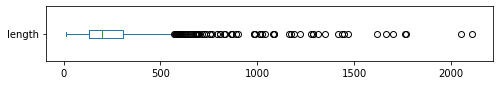

In [205]:
merged_lad_df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: >

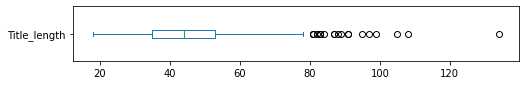

In [206]:
merged_lad_df['Title_length'] = merged_lad_df['Title'].str.len()
merged_lad_df['Title_length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: ylabel='Frequency'>

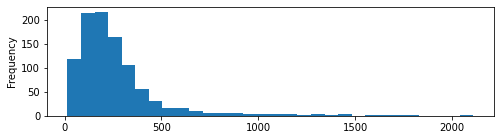

In [207]:
merged_lad_df['length'].plot(kind='hist', bins=30, figsize=(8,2))

<Axes: title={'center': 'Avg. Post Length'}, xlabel='Month'>

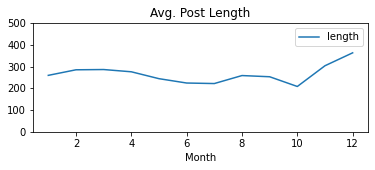

In [208]:
#Extract the month from the date and create a new column
merged_lad_df['Month'] = merged_lad_df['Date'].dt.month

#Plot the average post length
merged_lad_df.groupby('Month').agg({'length': 'mean'}) \
  .plot(title="Avg. Post Length", ylim=(0,500), figsize=(6,2))

In [209]:
def count_words(df, column='Contents_Normalized', preprocess=None, min_freq=2):

    #Process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    #Create counter and run through all data
    counter = Counter()
    tqdm.pandas() #initialize tqdm for progress bar
    df[column].apply(update)

    #Transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)


In [210]:
freq_df = count_words(merged_lad_df)
freq_df.head(5)

,freq
token,
dodger,3838
season,3300
year,2410
mm,2127
leagu,1861


In [211]:
#How many tokens are in the df?
len(freq_df)

6369

In [212]:
#Top words with 10+ characters
count_words(merged_lad_df, column='Content', 
            preprocess=lambda Content: re.findall(r"\w{10,}", Content)).head(5)


,freq
token,
appearances,642
assignment,281
outfielder,262
postseason,254
organization,236


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

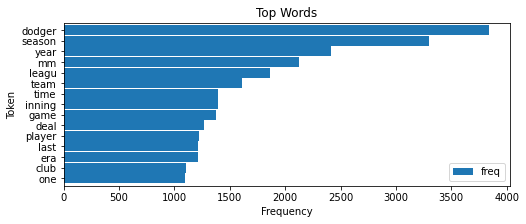

In [213]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# Combine merged team data into one dataframe for further analysis and modeling.

In [215]:
comb_df = pd.concat([merged_wsh_df, merged_sd_df, merged_oa_df, merged_cws_df, merged_laa_df, merged_lad_df], ignore_index= True)
len(comb_df)

6000

In [216]:
comb_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length,Title_length,Month
0,Nationals Designate Chad Kuhl For Assignment,Nick Deeds,2023-06-24,The Nationals announced this evening that the club has designated right-hander Chad Kuhl for ass...,2023,0,0,0.0,"[nation, announc, even, club, design, righthand, chad, kuhl, assign, correspond, move, washingto...",240,44,6
1,"Nationals Select Derek Hill, Place Victor Robles On Injured List",Steve Adams,2023-06-21,"The Nationals have selected the contract of outfielder Derek Hill from Triple-A Rochester, per a...",2023,0,0,0.0,"[nation, select, contract, outfield, derek, hill, triplea, rochest, per, team, announc, correspo...",239,64,6
2,"Nationals, Orioles Reach Settlement On 2012-16 MASN Rights Fees",Anthony Franco,2023-06-20,"The Nationals and Orioles have settled their dispute regarding MASN rights fees between 2012-16,...",2023,0,0,0.0,"[nation, oriol, settl, disput, regard, masn, right, fee, first, report, chelsea, jane, ben, stra...",274,63,6
3,"Sean Doolittle Completes Rehab Assignment, Heads To Triple-A Rochester",Steve Adams,2023-06-15,Veteran lefty Sean Doolittle was transferred from the Nationals’ Double-A affiliate to their Tri...,2023,0,0,0.0,"[veteran, lefti, sean, doolittl, transfer, nation, doublea, affili, triplea, club, thursday, sig...",60,70,6
4,Nationals Release Erasmo Ramírez,Darragh McDonald,2023-06-09,"The Nationals have released right-hander Erasmo Ramírez, according to his transactions tracker a...",2023,0,0,0.0,"[nation, releas, righthand, erasmo, ram, rez, accord, transact, tracker, mlbcom, design, assign,...",130,32,6


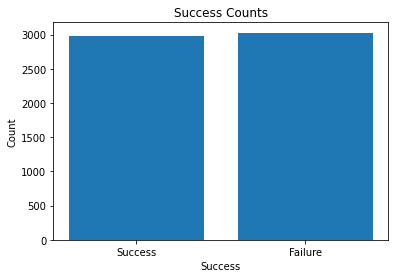

In [217]:
# Count the number of successes and failures
success_counts = comb_df['success'].value_counts()

# Create a bar plot
plt.bar(success_counts.index, success_counts.values)
plt.xticks(success_counts.index, ['Failure', 'Success'])
plt.xlabel('Success')
plt.ylabel('Count')
plt.title('Success Counts')

# Display the plot
plt.show()

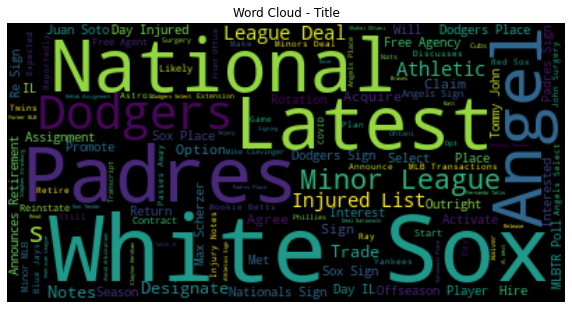

In [218]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt   

 # Create a word cloud for the "Title" column
title_wordcloud = WordCloud().generate(' '.join(comb_df['Title'].dropna()))
plt.figure(figsize=(10, 6))
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Title')
plt.show()

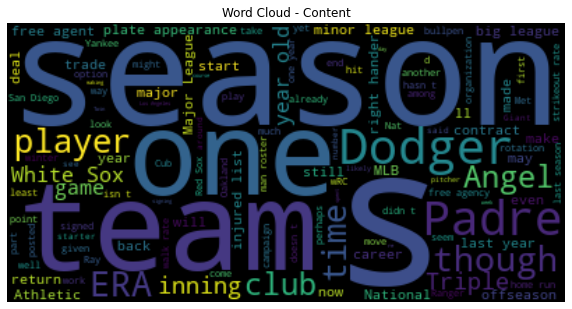

In [219]:
# Create a word cloud for the "Contents_Normalized" column
contents_wordcloud = WordCloud().generate(' '.join(comb_df['Content'].dropna()))
plt.figure(figsize=(10, 6))
plt.imshow(contents_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Content')
plt.show()

# Topic Modeling

In [224]:
stopwords = list(stopwords)
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(comb_df['Content'])
tfidf_text_vectors.shape

(6000, 12111)

In [225]:
from sklearn.decomposition import NMF

nmf_text_model = NMF(n_components=10, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [226]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

def display_topics(model, feature_names, no_top_words=5):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx}:")
        top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        for feature, weight in zip(top_features, weights):
            print(f"{feature} ({weight})")

In [227]:
tfidf_feature_names = list(tfidf_text_vectorizer.vocabulary_.keys())
display_topics(nmf_text_model, tfidf_feature_names)


Topic 0:
pagan (0.6148124755426609)
colas (0.608102953805686)
cuts (0.5956734841045294)
gosselin (0.5442948119434579)
lieutenant (0.5215348253110752)

Topic 1:
kt (0.6314216353220825)
224 (0.6055153923434654)
held (0.4633310611812178)
garza (0.44960233614118694)
interests (0.40199714333662223)

Topic 2:
pattern (1.4610200879160924)
avoidance (1.2640173978130975)
simeon (0.5720011132254754)
allen (0.3801362139696933)
donny (0.35416022944434306)

Topic 3:
000 (1.155462964992141)
delaplane (1.094642059657612)
eighty (0.9215887565063594)
224 (0.5592900793112495)
kay (0.5083019607414038)

Topic 4:
culture (1.447942461361509)
oscar (0.7886763000463056)
perception (0.6667427257964942)
committal (0.47919956459944407)
393 (0.39497219808913914)

Topic 5:
stratton (1.8615727805768556)
trent (0.9494023156369307)
fanbases (0.5188406530318043)
uncomfortable (0.5141113800589384)
eclipse (0.4834722600626102)

Topic 6:
characterizes (1.0552092668550668)
425mm (0.8180447661698501)
schaaf (0.69663828094

# Modeling

## Logistic Regression Modeling

In [228]:
!pip install scikit-learn

In [229]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [230]:
X_train, X_test, y_train, y_test = train_test_split(comb_df['Content'], comb_df['success'], test_size=0.2, random_state=42)

In [231]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [232]:
model = LogisticRegression()
model.fit(X_train_vec, y_train)

LogisticRegression()

In [233]:
y_pred = model.predict(X_test_vec)

In [234]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7758333333333334


## Penalized Logistic Regression

In [235]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

In [236]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, cv=5)
grid_search.fit(X_train_vec, y_train)

best_C = grid_search.best_params_['C']

In [237]:
model = LogisticRegression(penalty='l2', C=best_C)
model.fit(X_train_vec, y_train)

LogisticRegression(C=1)

In [238]:
y_pred = model.predict(X_test_vec)

In [239]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.7758333333333334
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       627
           1       0.76      0.77      0.77       573

    accuracy                           0.78      1200
   macro avg       0.78      0.78      0.78      1200
weighted avg       0.78      0.78      0.78      1200



In [240]:
coefficients = model.coef_
print(coefficients)

[[ 0.00694685 -0.07996149 -0.03090452 ... -0.05781421 -0.00909974
  -0.10094782]]


In [241]:
# Retrieve feature names from vectorizer
feature_names = vectorizer.get_feature_names_out()

# Calculate feature importance
feature_importance = np.abs(model.coef_[0])

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

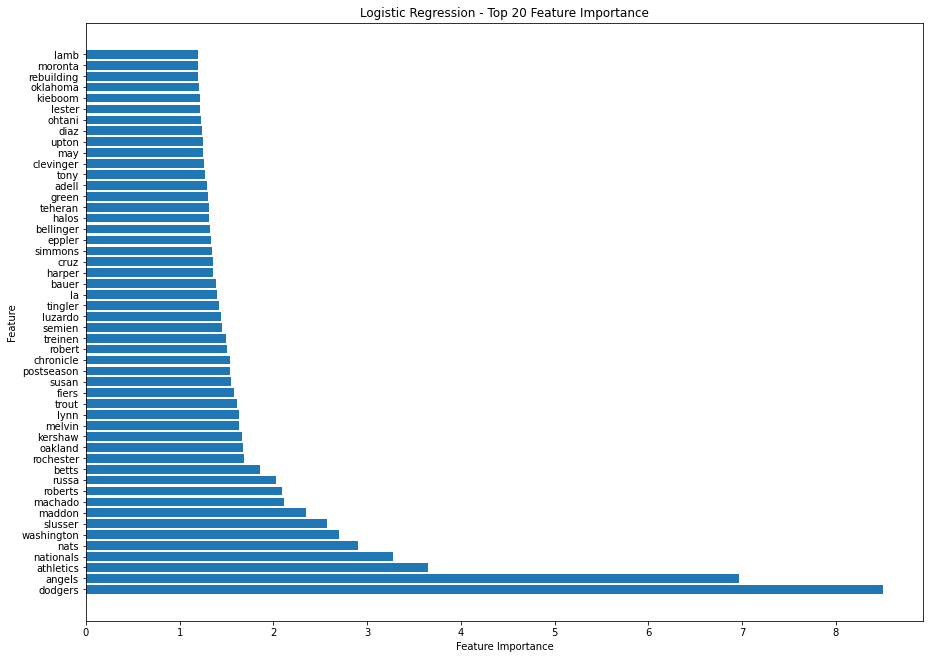

In [243]:
# Select top 20 features
top_feature_importance = sorted_feature_importance[:50]
top_feature_names = sorted_feature_names[:50]

# Plot top 20 feature importance
plt.figure(figsize=(15, 11))
plt.barh(range(len(top_feature_names)), top_feature_importance, align='center')
plt.yticks(range(len(top_feature_names)), top_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Logistic Regression - Top 20 Feature Importance')
plt.show()